In [ ]:
!sudo apt install libavdevice-dev libavfilter-dev libavformat-dev libavcodec-dev libavutil-dev
!apt install -y ffmpeg
!pip install av

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libavcodec-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavcodec-dev set to manually installed.
libavformat-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavformat-dev set to manually installed.
libavutil-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavutil-dev set to manually installed.
The following additional packages will be installed:
  libpostproc-dev
The following NEW packages will be installed:
  libavdevice-dev libavfilter-dev libpostproc-dev
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,890 kB of archives.
After this operation, 8,444 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpostproc-dev amd64 7:4.4.2-0ubuntu0.22.04.1 [60.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libavfilter-dev amd64 7:4.4.2-

In [ ]:
!pip install mediapipe opencv-python torch torchvision torchaudio

Path to dataset files: /kaggle/input/workoutfitness-video


In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("hasyimabdillah/workoutfitness-video")

print("Path to dataset files:", path)
labels_dir = os.path.join(path)
# List all files and directories in the labels directory
all_items = os.listdir(labels_dir)

# Filter for directories (which represent the labels)
labels = [item for item in all_items if os.path.isdir(os.path.join(labels_dir, item))]

print("Labels:", labels)
print("Number of labels:", len(labels))

Path to dataset files: /kaggle/input/workoutfitness-video
Labels: ['t bar row', 'pull Up', 'hammer curl', 'decline bench press', 'tricep Pushdown', 'chest fly machine', 'squat', 'bench press', 'push-up', 'deadlift', 'leg raises', 'russian twist', 'barbell biceps curl', 'lateral raise', 'hip thrust', 'lat pulldown', 'plank', 'incline bench press', 'tricep dips', 'leg extension', 'romanian deadlift', 'shoulder press']
Number of labels: 22


In [ ]:
import os, hashlib, warnings, random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import mediapipe as mp

# Silence Mediapipe / TF-Lite spam
os.environ["GLOG_minloglevel"] = "2"
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42
random.seed(SEED);  np.random.seed(SEED);  torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False


In [ ]:
DATASET_ROOT = Path(path)
assert DATASET_ROOT.exists(), "DATASET_ROOT does not exist"

records = []
for cls_dir in sorted([p for p in DATASET_ROOT.iterdir() if p.is_dir()]):
    for mp4 in cls_dir.glob("*.mp4"):
        records.append({"filepath": str(mp4.resolve()),
                        "label"   : cls_dir.name.lower()})

df      = pd.DataFrame(records).sample(frac=1, random_state=SEED).reset_index(drop=True)
labels  = sorted(df.label.unique())
label2i = {l:i for i,l in enumerate(labels)}
df["label_idx"] = df.label.map(label2i)

train_df, val_df = train_test_split(df, test_size=0.2,
                                    stratify=df.label_idx, random_state=SEED)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

##Plots

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


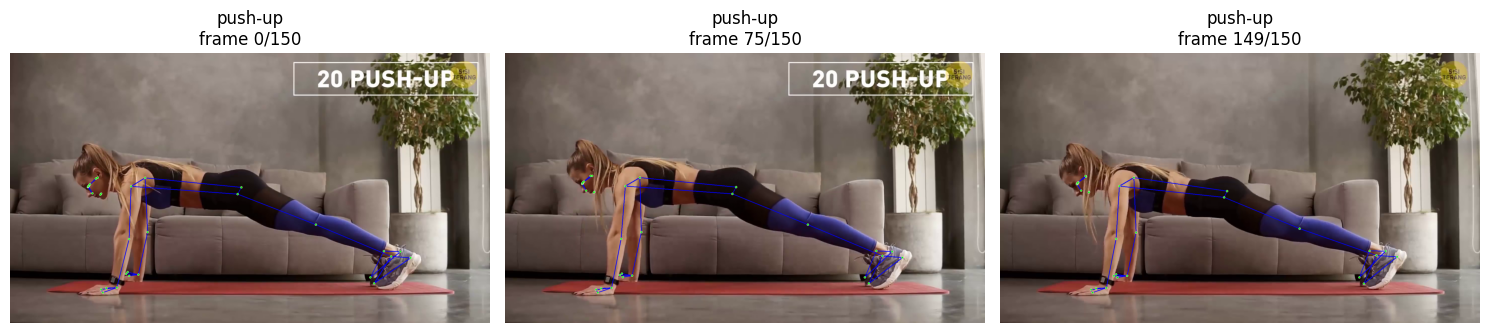

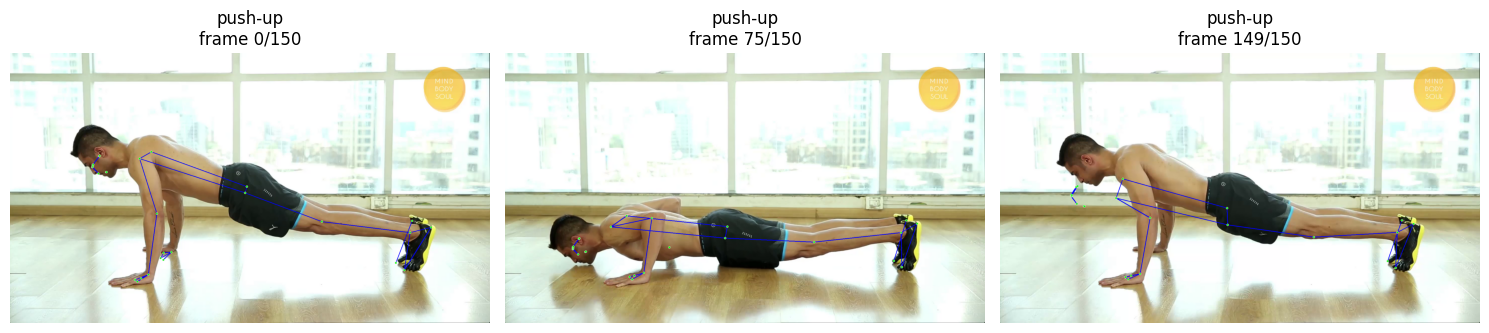

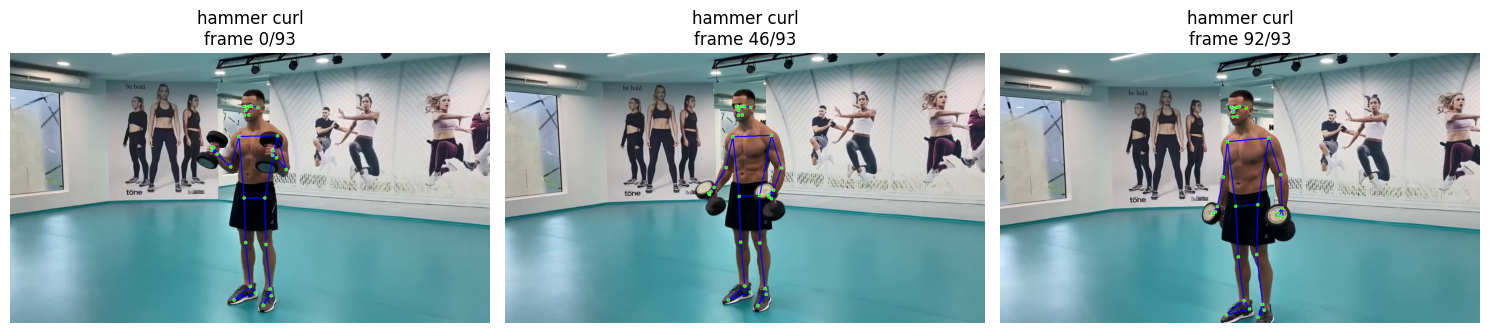

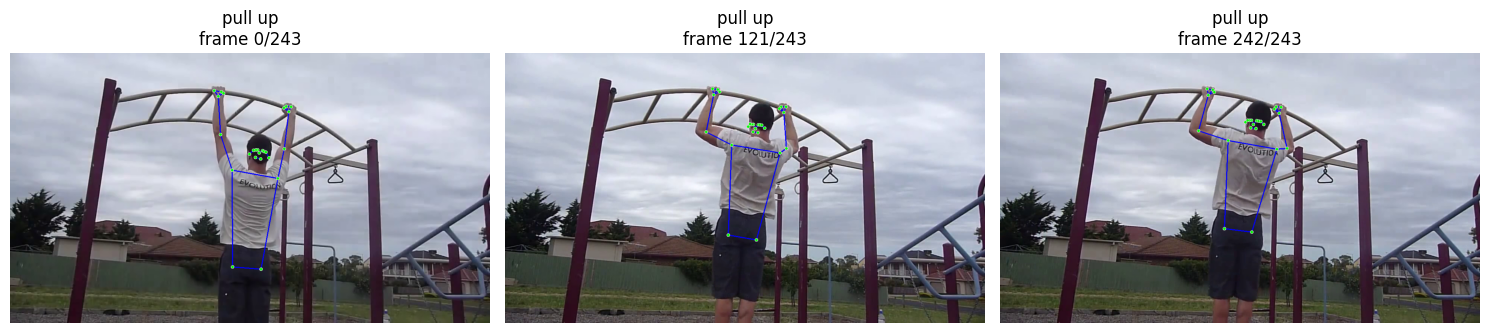

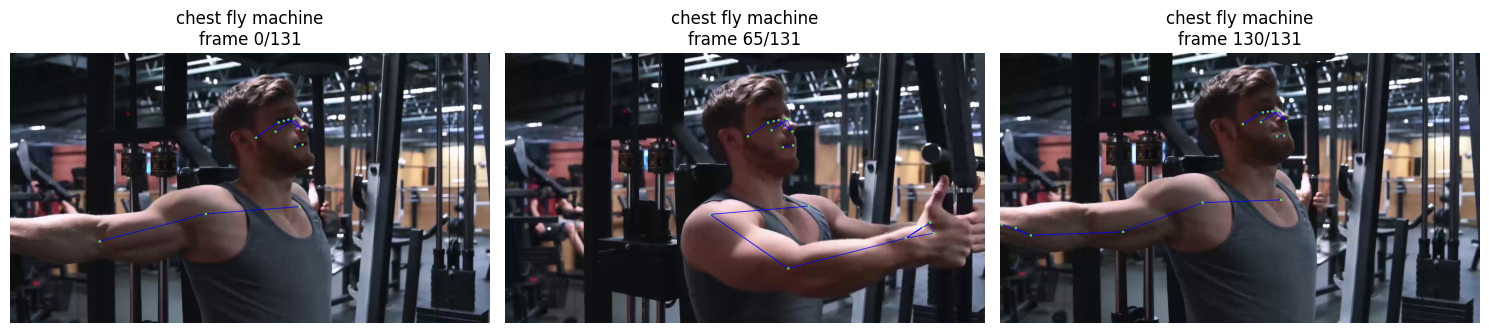

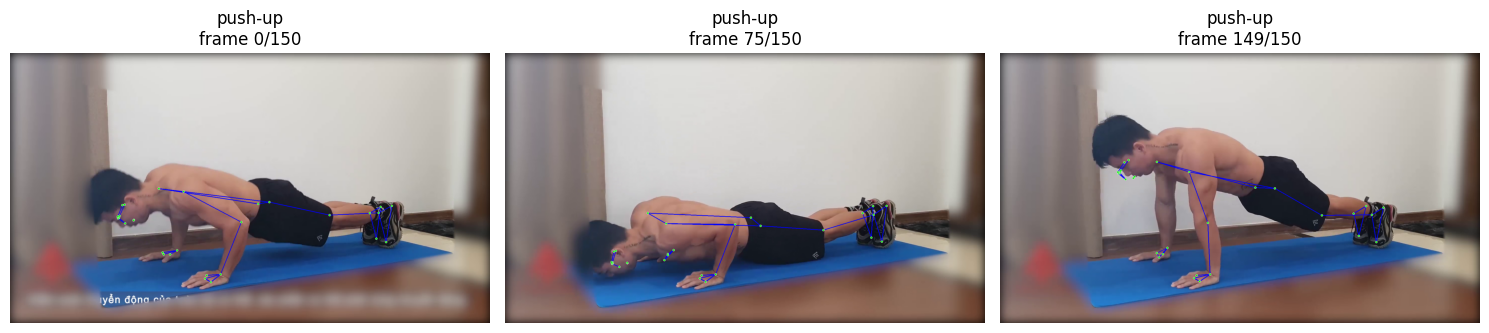

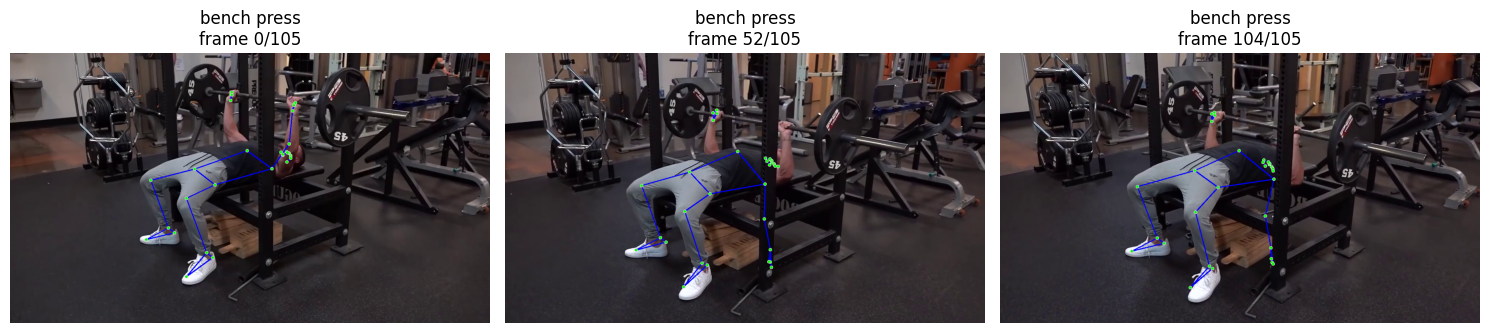

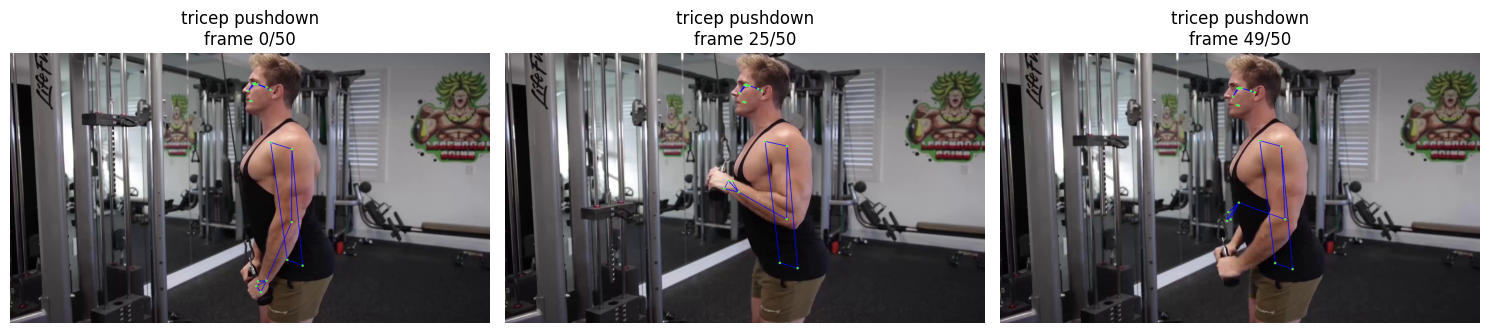

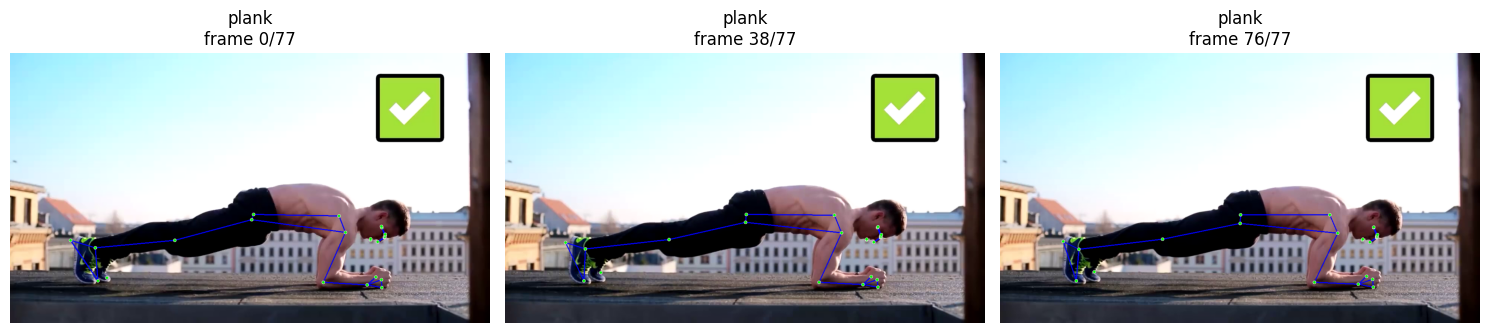

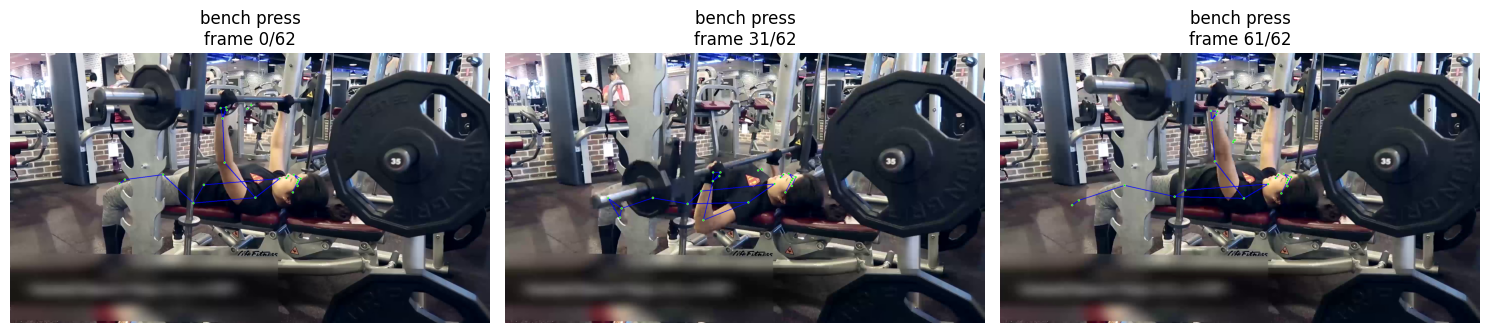

In [ ]:
# 1. Imports
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe import solutions

# 2. Set up the same estimator you used for caching
mp_pose        = mp.solutions.pose
pose_estimator = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
for i in range(10):

  # 3. Grab the drawing utils from mp.solutions
  mp_drawing    = mp.solutions.drawing_utils
  mp_connections = mp.solutions.pose.POSE_CONNECTIONS

  # 4. Pick a random video
  rand_idx   = random.choice(train_df.index.tolist())
  video_fp   = train_df.loc[rand_idx, 'filepath']
  label_name = train_df.loc[rand_idx, 'label']
  pose_estimator.reset()
  # 5. Read three frames: first, middle, last
  cap          = cv2.VideoCapture(video_fp)
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_idxs   = [0, total_frames//2, total_frames-1]
  frames_out   = []

  for i in range(total_frames):
      ret, frame = cap.read()
      if not ret:
          break
      if i in frame_idxs:
          img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          res     = pose_estimator.process(img_rgb)
          out_img = img_rgb.copy()
          if res.pose_landmarks:
              # draw landmarks + connections
              mp_drawing.draw_landmarks(
                  out_img,
                  res.pose_landmarks,
                  mp_connections,
                  mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
                  mp_drawing.DrawingSpec(color=(0,0,255), thickness=2)
              )
          frames_out.append(out_img)

  cap.release()

  # 6. Plot
  fig, axes = plt.subplots(1, len(frames_out), figsize=(15,5))
  for ax, img, idx in zip(axes, frames_out, frame_idxs):
      ax.imshow(img)
      ax.set_title(f"{label_name}\nframe {idx}/{total_frames}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()


In [ ]:
#!/usr/bin/env python3
"""
Workout/Fitness Video Classifier (Accelerated) with one-off precompute,
fast I/O, mixed precision, and DataLoader optimizations.
"""
import os
import random
import warnings
from pathlib import Path
import argparse

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.backends import cudnn
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.models.hub import slowfast_r50
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# --------------------------------------
#  Configurable constants
# --------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Video/mask properties
SIZE = 224           # spatial size
FRAMES = 32          # number of frames
ALPHA = 4            # SlowFast ratio
MEAN = (0.45, 0.45, 0.45)
STD = (0.225, 0.225, 0.225)

# Training hyperparams
BATCH = 16           # reduced batch size
LR = 1e-4
EPOCHS = 8
N_FOLDS = 5

# Paths (modify as needed)
DATA_ROOT = Path(os.getenv("DATA_ROOT", "/kaggle/input/workoutfitness-video"))
MASK_DIR = Path(os.getenv("MASK_DIR", "./pose_masks"))
PREP_DIR = Path(os.getenv("PREP_DIR", "./precomputed"))

# -----------------------------------------------------------------------------
#  Utility functions
# -----------------------------------------------------------------------------
def rgb_transform(video: torch.Tensor) -> torch.Tensor:
    """Resize + normalize a [T,3,H,W] tensor."""
    video = F.interpolate(video, size=(SIZE, SIZE), mode='bilinear', align_corners=False)
    mean = torch.tensor(MEAN).view(1, 3, 1, 1, device=video.device)
    std = torch.tensor(STD).view(1, 3, 1, 1, device=video.device)
    return (video - mean) / std


def uniform_subsample(x: torch.Tensor, num_samples=FRAMES) -> torch.Tensor:
    """Uniformly subsample (or leave) frames along time dimension."""
    T = x.shape[0]
    if T <= num_samples:
        return x
    idxs = torch.linspace(0, T - 1, num_samples).long()
    return x[idxs]


def pad_or_trim(x: torch.Tensor, T=FRAMES) -> torch.Tensor:
    """Pad (repeat last) or trim time axis to length T."""
    cur = x.shape[0]
    if cur == T:
        return x
    if cur < T:
        pad = x[-1:].repeat(T - cur, *([1] * (x.ndim - 1)))
        return torch.cat([x, pad], dim=0)
    return x[:T]

# -----------------------------------------------------------------------------
#  Step 1: Build DataFrame of all videos
# -----------------------------------------------------------------------------
def build_dataframe():
    MERGE = {
        "bench press": "bench press", "incline bench press": "bench press",
        "decline bench press": "bench press", "barbell biceps curl": "bicep curl",
        "hammer curl": "bicep curl", "deadlift": "deadlift",
        "romanian deadlift": "deadlift", "lat pulldown": "lat pulling",
        "pull up": "lat pulling",
    }
    DROP = {"plank"}

    recs = []
    for cls_dir in DATA_ROOT.iterdir():
        if not cls_dir.is_dir():
            continue
        raw = cls_dir.name.lower()
        if raw in DROP:
            continue
        label = MERGE.get(raw, raw)
        for mp4 in cls_dir.glob("*.mp4"):
            recs.append({"filepath": str(mp4), "label": label, "raw": raw})
    df = pd.DataFrame(recs)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    classes = sorted(df.label.unique())
    label2id = {c: i for i, c in enumerate(classes)}
    df["label_idx"] = df.label.map(label2id)
    return df, classes

# -----------------------------------------------------------------------------
#  Step 2: One-off precompute slow/fast tensors
# -----------------------------------------------------------------------------
def precompute(df: pd.DataFrame):
    PREP_DIR.mkdir(exist_ok=True)
    for row in tqdm(df.itertuples(index=False), total=len(df), desc="Precomputing videos"):
        stem = Path(row.filepath).stem.replace(" ", "_")
        out_file = PREP_DIR / f"{stem}.pt"
        if out_file.exists():
            continue

        # 1) decode with PyTorchVideo
        ev = EncodedVideo.from_path(row.filepath)
        video = ev.get_clip(start_sec=0, end_sec=ev.duration)["video"]  # [T,3,H,W]
        video = uniform_subsample(video, FRAMES)
        video = pad_or_trim(video, FRAMES)
        video = rgb_transform(video)

        # 2) load pose mask
        mask_file = MASK_DIR / f"{stem}.pt"
        mask = torch.load(mask_file)  # [T,1,H,W]
        mask = uniform_subsample(mask, FRAMES)
        mask = pad_or_trim(mask, FRAMES)

        # 3) fuse and build slow/fast
        fusion = torch.cat([video, mask], dim=1)          # [T,4,H,W]
        fast = fusion.permute(1, 0, 2, 3).contiguous()
        slow = fusion[::ALPHA].permute(1, 0, 2, 3).contiguous()

        torch.save({"fast": fast, "slow": slow, "label": row.label_idx}, out_file)

# -----------------------------------------------------------------------------
#  Dataset for precomputed data
# -----------------------------------------------------------------------------
class PrecompDS(Dataset):
    def __init__(self, file_list):
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        return [data['slow'], data['fast']], data['label']

# -----------------------------------------------------------------------------
#  Build SlowFast-4ch model
# -----------------------------------------------------------------------------
def build_slowfast_4ch(num_classes: int):
    model = slowfast_r50(pretrained=True)
    # modify slow & fast first convs to 4 channels
    for i in (0, 1):
        old = model.blocks[0].multipathway_blocks[i].conv
        new = nn.Conv3d(4, old.out_channels, old.kernel_size, old.stride, old.padding, bias=False)
        with torch.no_grad():
            new.weight[:, :3] = old.weight
            new.weight[:, 3] = old.weight.mean(1)
        model.blocks[0].multipathway_blocks[i].conv = new
    # modify head
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, num_classes)
    return model

# -----------------------------------------------------------------------------
#  Training & validation loops
# -----------------------------------------------------------------------------
def train_one_epoch(model, dl, opt, scaler, device, scheduler=None):
    model.train()
    total_loss = 0.0
    for (slow, fast), labels in dl:
        slow, fast, labels = slow.to(device), fast.to(device), labels.to(device)
        opt.zero_grad()
        with autocast():
            logits = model([slow, fast])
            loss = F.cross_entropy(logits, labels, label_smoothing=0.1)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dl)


def validate(model, dl, device):
    model.eval()
    correct = total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for (slow, fast), labels in dl:
            slow, fast, labels = slow.to(device), fast.to(device), labels.to(device)
            preds = model([slow, fast]).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    return correct / total, y_true, y_pred




In [ ]:

# -----------------------------------------------------------------------------
#  Colab entrypoint
# -----------------------------------------------------------------------------
# 1) Enable cuDNN autotuner
cudnn.benchmark = True

# 2) Build the DataFrame & get class list
df, classes = build_dataframe()

# 3) (Optional) Precompute features
#    Run this cell once—uncomment to precompute the .pt files, then re-run without this.
precompute(df)
print("Done precomputing. Now comment out precompute() and re-run to train.")

# 4) Prepare cross-val splits & device
skf    = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5) Run 5-fold CV
fold_results = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(df, df.label_idx), start=1):
    print(f"\n=== Fold {fold}/{N_FOLDS} ===")
    # Build file lists
    train_files = [PREP_DIR / f"{Path(df.iloc[i].filepath).stem.replace(' ', '_')}.pt" for i in tr_idx]
    val_files   = [PREP_DIR / f"{Path(df.iloc[i].filepath).stem.replace(' ', '_')}.pt" for i in val_idx]

    # Datasets & Loaders
    train_dl = DataLoader(
        PrecompDS(train_files), batch_size=BATCH, shuffle=True,
        num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2
    )
    val_dl = DataLoader(
        PrecompDS(val_files), batch_size=BATCH, shuffle=False,
        num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2
    )

    # Model, optimizer, scheduler, scaler
    model     = build_slowfast_4ch(len(classes)).to(device)
    optimizer = optim.AdamW(model.parameters(), LR)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                              steps_per_epoch=len(train_dl),
                                              epochs=EPOCHS)
    scaler = GradScaler()

    # Training loop
    best_acc = 0.0
    for epoch in range(1, EPOCHS + 1):
        loss    = train_one_epoch(model, train_dl, optimizer, scaler, device, scheduler)
        val_acc, _, _ = validate(model, val_dl, device)
        print(f"Epoch {epoch}/{EPOCHS} → loss {loss:.4f}, val_acc {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_fold{fold}.pth")

    print(f"Fold {fold} best acc: {best_acc:.4f}")
    fold_results.append(best_acc)

# 6) Final summary
mean_acc = float(np.mean(fold_results))
std_acc  = float(np.std(fold_results))
print(f"\nOverall: {mean_acc:.4f} ± {std_acc:.4f}")


Precomputing videos:   0%|          | 0/584 [00:00<?, ?it/s]

In [ ]:
!pip install pytorchvideo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=5d61b6c4a9a083ed3705bd8182cccf0786b485f81d14d2537a5b3186f06de07d
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
Successfully built pytorchvideo


In [ ]:
data = [video_fp,label_name,frame_idxs]

▶️  Building/validating cache …


Caching train:   0%|          | 0/472 [00:00<?, ?it/s]

Caching val:   0%|          | 0/118 [00:00<?, ?it/s]

✅  Cache ready!


Train 01:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 01] Train 3.81% | Val 5.08% (lr=3.0e-04)


Train 02:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 02] Train 11.65% | Val 6.78% (lr=3.0e-04)


Train 03:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 03] Train 19.07% | Val 12.71% (lr=3.0e-04)


Train 04:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 04] Train 25.21% | Val 16.10% (lr=2.9e-04)


Train 05:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 05] Train 25.85% | Val 21.19% (lr=2.9e-04)


Train 06:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 06] Train 31.99% | Val 25.42% (lr=2.8e-04)


Train 07:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 07] Train 35.17% | Val 30.51% (lr=2.8e-04)


Train 08:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 08] Train 45.34% | Val 30.51% (lr=2.7e-04)


Train 09:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 09] Train 39.19% | Val 33.05% (lr=2.7e-04)


Train 10:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 10] Train 49.58% | Val 35.59% (lr=2.6e-04)


Train 11:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 11] Train 48.52% | Val 35.59% (lr=2.5e-04)


Train 12:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 12] Train 47.88% | Val 45.76% (lr=2.4e-04)


Train 13:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 13] Train 60.81% | Val 43.22% (lr=2.3e-04)


Train 14:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 14] Train 58.69% | Val 44.07% (lr=2.2e-04)


Train 15:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 15] Train 60.59% | Val 51.69% (lr=2.1e-04)


Train 16:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 16] Train 61.02% | Val 50.85% (lr=2.0e-04)


Train 17:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 17] Train 62.50% | Val 51.69% (lr=1.9e-04)


Train 18:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 18] Train 63.98% | Val 52.54% (lr=1.8e-04)


Train 19:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 19] Train 61.23% | Val 54.24% (lr=1.7e-04)


Train 20:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 20] Train 69.70% | Val 55.08% (lr=1.6e-04)


Train 21:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 21] Train 68.43% | Val 55.93% (lr=1.4e-04)


Train 22:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 22] Train 64.62% | Val 55.08% (lr=1.3e-04)


Train 23:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 23] Train 67.80% | Val 54.24% (lr=1.2e-04)


Train 24:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 24] Train 66.74% | Val 55.93% (lr=1.1e-04)


Train 25:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 25] Train 70.55% | Val 59.32% (lr=1.0e-04)


Train 26:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 26] Train 73.09% | Val 59.32% (lr=8.9e-05)


Train 27:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 27] Train 72.46% | Val 59.32% (lr=7.9e-05)


Train 28:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 28] Train 75.85% | Val 62.71% (lr=7.0e-05)


Train 29:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 29] Train 72.25% | Val 63.56% (lr=6.1e-05)


Train 30:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 30] Train 72.25% | Val 62.71% (lr=5.2e-05)


Train 31:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 31] Train 73.73% | Val 62.71% (lr=4.5e-05)


Train 32:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 32] Train 75.00% | Val 63.56% (lr=3.8e-05)


Train 33:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 33] Train 76.27% | Val 63.56% (lr=3.1e-05)


Train 34:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 34] Train 79.03% | Val 65.25% (lr=2.6e-05)


Train 35:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 35] Train 76.48% | Val 63.56% (lr=2.1e-05)


Train 36:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 36] Train 72.88% | Val 63.56% (lr=1.7e-05)


Train 37:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 37] Train 74.15% | Val 66.10% (lr=1.4e-05)


Train 38:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 38] Train 76.06% | Val 65.25% (lr=1.2e-05)


Train 39:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 39] Train 75.42% | Val 65.25% (lr=1.0e-05)


Train 40:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 40] Train 77.12% | Val 65.25% (lr=1.0e-05)


Train 41:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 41] Train 76.69% | Val 65.25% (lr=1.0e-05)


Train 42:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 42] Train 75.85% | Val 64.41% (lr=1.2e-05)


Train 43:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 43] Train 79.45% | Val 64.41% (lr=1.4e-05)


Train 44:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 44] Train 79.24% | Val 63.56% (lr=1.7e-05)


Train 45:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 45] Train 77.75% | Val 63.56% (lr=2.1e-05)


Train 46:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 46] Train 76.27% | Val 63.56% (lr=2.6e-05)


Train 47:   0%|          | 0/59 [00:00<?, ?it/s]

[Ep 47] Train 75.42% | Val 62.71% (lr=3.1e-05)
🛑 Early stopping

Best val accuracy: 0.661
                     precision    recall  f1-score   support

barbell biceps curl       0.75      0.46      0.57        13
        bench press       1.00      0.42      0.59        12
  chest fly machine       0.67      1.00      0.80         6
           deadlift       1.00      0.17      0.29         6
decline bench press       0.12      1.00      0.22         1
        hammer curl       0.33      0.50      0.40         2
         hip thrust       1.00      0.33      0.50         3
incline bench press       0.67      0.57      0.62         7
       lat pulldown       1.00      0.60      0.75        10
      lateral raise       0.50      0.83      0.62         6
      leg extension       0.50      0.50      0.50         4
         leg raises       1.00      1.00      1.00         3
              plank       0.50      1.00      0.67         1
            pull up       0.56      1.00      0.71     

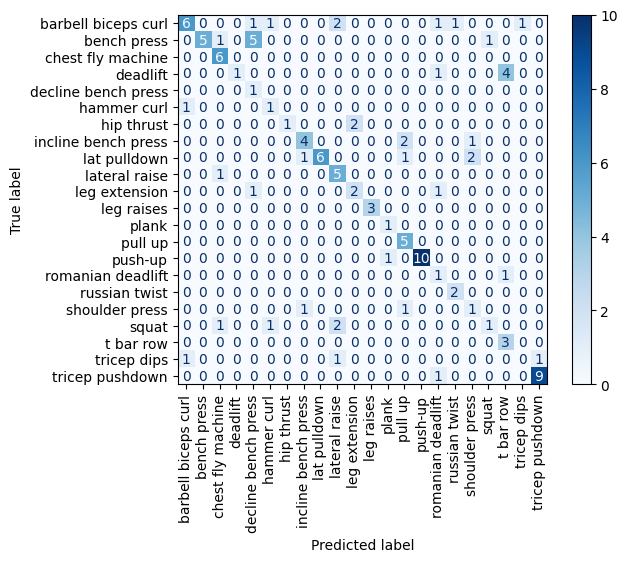

In [ ]:
# Pose-based Workout Classifier – v2
# ---------------------------------
# Implements the quick-win improvements discussed:
#   • Angle-feature side-channel  (adds 8 joint-angles per frame)
#   • Focal-Loss (class-balanced)
#   • 3-window voting during inference
# Parts *not* yet implemented (see bottom of file).

import os, hashlib, warnings, random, math
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import mediapipe as mp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- 1. deterministic setup -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------- 2. dataset discovery ---------------------------
DATASET_ROOT = Path(path)   # <<<<<<<<<<  EDIT  <<<<<<<<<<
assert DATASET_ROOT.exists(), "DATASET_ROOT does not exist"

records = []
for cls_dir in sorted([p for p in DATASET_ROOT.iterdir() if p.is_dir()]):
    for mp4 in cls_dir.glob("*.mp4"):
        records.append({"filepath": str(mp4.resolve()),
                        "label"   : cls_dir.name.lower()})

full_df = pd.DataFrame(records).sample(frac=1, random_state=SEED).reset_index(drop=True)
LABELS  = sorted(full_df.label.unique())
label2i = {l:i for i,l in enumerate(LABELS)}
full_df["label_idx"] = full_df.label.map(label2i)

train_df, val_df = train_test_split(full_df, test_size=0.2, stratify=full_df.label_idx,
                                    random_state=SEED)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# -------------------- 3. pose + angle encoding -----------------------
mp_pose    = mp.solutions.pose
NUM_FRAMES = 32
CACHE_DIR  = Path("pose_cache_v2"); CACHE_DIR.mkdir(exist_ok=True)

ANGLE_TRIOS = {
    #   name : (a,b,c) landmark indices (b is the vertex)
    "l_elbow"  : (11,13,15),
    "r_elbow"  : (12,14,16),
    "l_knee"   : (23,25,27),
    "r_knee"   : (24,26,28),
    "l_hip"    : (25,23,11),   # hip angle torso-leg
    "r_hip"    : (26,24,12),
    "l_shldr"  : (13,11,23),
    "r_shldr"  : (14,12,24),
}
N_ANGLES = len(ANGLE_TRIOS)


def _angle(a, b, c):
    """Return angle (in rad) between BA and BC (0-π). a,b,c are (3,) numpy."""
    ba, bc = a - b, c - b
    ba_norm = ba / (np.linalg.norm(ba) + 1e-6)
    bc_norm = bc / (np.linalg.norm(bc) + 1e-6)
    cosang = np.clip(np.dot(ba_norm, bc_norm), -1.0, 1.0)
    return math.acos(cosang)


def compute_angles(landmarks):
    """landmarks shape (33,4) – returns (N_ANGLES,) float32 of radians."""
    pts = landmarks[:, :3]  # x,y,z
    out = []
    for a, b, c in ANGLE_TRIOS.values():
        out.append(_angle(pts[a], pts[b], pts[c]))
    return np.asarray(out, np.float32)


def encode_video(path: str, n_frames: int = NUM_FRAMES):
    """Return (T, 132 + N_ANGLES) float32, centred at left-hip."""
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        cap.release()
        return np.zeros((n_frames, 132 + N_ANGLES), np.float32)

    idxs = np.linspace(0, total-1, n_frames, dtype=int)
    seq_pose, seq_angle = [], []
    with mp_pose.Pose(static_image_mode=False,
                      model_complexity=1,
                      smooth_landmarks=True,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5) as pose:
        for i in range(total):
            ret, frame = cap.read();
            if not ret: break
            if i in idxs:
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = pose.process(img)
                if not res.pose_landmarks:
                    lm = np.zeros((33,4), np.float32)
                else:
                    lm = np.array([[p.x, p.y, p.z, p.visibility] for p in res.pose_landmarks.landmark],
                                  np.float32)
                # translate by left-hip
                lm[:, :3] -= lm[23, :3]
                seq_pose.append(lm.reshape(-1))
                seq_angle.append(compute_angles(lm))
    cap.release()
    # pad if not enough frames
    while len(seq_pose) < n_frames:
        seq_pose.append(seq_pose[-1] if seq_pose else np.zeros(33*4, np.float32))
        seq_angle.append(seq_angle[-1] if seq_angle else np.zeros(N_ANGLES, np.float32))
    pose_arr  = np.stack(seq_pose)           # (T,132)
    angle_arr = np.stack(seq_angle)          # (T,N_ANGLES)
    return np.concatenate([pose_arr, angle_arr], axis=-1)  # (T,D)


def ck(path:str)->str:
    return hashlib.md5(path.encode()).hexdigest()+".npy"


def build_cache(split:str, frame:pd.DataFrame):
    tgt = CACHE_DIR/split; tgt.mkdir(exist_ok=True)
    for _,row in tqdm(frame.iterrows(), total=len(frame), desc=f"Caching {split}"):
        f = tgt/ck(row.filepath)
        if not f.exists():
            np.save(f, encode_video(row.filepath))

print("▶️  Building/validating cache …")
build_cache("train", train_df)
build_cache("val",   val_df)
print("✅  Cache ready!")

# -------------------- 4. augmentation & dataset ----------------------
AUGMENTOFF = False

class CachedPoseDS(Dataset):
    def __init__(self, df:pd.DataFrame, split:str):
        self.df  = df.reset_index(drop=True)
        self.dir = CACHE_DIR/split
        self.train = split == "train"
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        x = torch.tensor(np.load(self.dir/ck(row.filepath)), dtype=torch.float32)  # (T,D)
        if self.train and not AUGMENTOFF:
            # simple noise + left-right flip on pose only (angles recompute implied)
            if torch.rand(1) < 0.5:
                x[:,:132:4] *= -1   # flip X coords (quick hack)
            x += 0.003 * torch.randn_like(x)
        y = torch.tensor(row.label_idx, dtype=torch.long)
        return x, y

train_ds = CachedPoseDS(train_df, "train")
val_ds   = CachedPoseDS(val_df,   "val")

# class-balanced sampler
cnt = train_df.groupby("label_idx").size().to_numpy()
sampler_w = 1/np.sqrt(cnt[train_ds.df.label_idx.to_numpy()])
sampler   = WeightedRandomSampler(sampler_w, num_samples=len(train_ds), replacement=True)

train_dl = DataLoader(train_ds, batch_size=8, sampler=sampler, num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# -------------------- 5. model ---------------------------------------
D_IN = 33*4 + N_ANGLES  # 132 + 8 = 140

class PositionalEncoding(nn.Module):
    def __init__(self, max_len:int, d:int):
        super().__init__()
        self.pos = nn.Parameter(torch.zeros(1, max_len, d))
        nn.init.trunc_normal_(self.pos, std=0.02)
    def forward(self, x):
        return x + self.pos[:, :x.size(1)]

class PoseTransformer(nn.Module):
    def __init__(self, num_classes, d_model=D_IN, n_layers=4, nhead=4, dim_ff=512, dropout=0.3):
        super().__init__()
        self.pos = PositionalEncoding(NUM_FRAMES+1, d_model)
        self.enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True),
            num_layers=n_layers)
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes))
    def forward(self, x):           # x [B,T,D]
        cls = torch.zeros(x.size(0), 1, x.size(2), dtype=x.dtype, device=x.device)
        x   = torch.cat([cls, x], dim=1)
        x   = self.pos(x)
        h   = self.enc(x)[:, 0]     # CLS token
        return self.cls_head(h)

# -------------------- 6. Focal loss ----------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma; self.weight = weight; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class_w = torch.tensor(1 / np.sqrt(cnt), dtype=torch.float32, device=device)
criterion = FocalLoss(gamma=2.0, weight=class_w).to(device)


# -------------------- 7. training setup -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = PoseTransformer(num_classes=len(LABELS)).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

EPOCHS, PATIENCE = 50, 10
best_acc = 0.0; bad = 0
history = dict(tr=[], vl=[])

for ep in range(1, EPOCHS+1):
    # ---- train ----
    model.train(); tl, tc = 0.0, 0
    for x, y in tqdm(train_dl, desc=f'Train {ep:02d}', leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    tr_acc = tc / len(train_ds)

    # ---- val ----
    model.eval(); vl, vc = 0.0, 0; all_p, all_t = [], []
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            vc += (out.argmax(1) == y).sum().item()
            all_p.extend(out.argmax(1).cpu()); all_t.extend(y.cpu())
    vl_acc = vc / len(val_ds)
    history['tr'].append(tr_acc); history['vl'].append(vl_acc)
    scheduler.step()

    print(f"[Ep {ep:02d}] Train {tr_acc:.2%} | Val {vl_acc:.2%} (lr={scheduler.get_last_lr()[0]:.1e})")

    if vl_acc > best_acc:
        best_acc, bad = vl_acc, 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        bad += 1
        if bad >= PATIENCE:
            print('🛑 Early stopping')
            break

# -------------------- 8. inference helper – 3-window voting ----------

def predict_video(model, filepath, n_windows=3):
    """Return predicted label_idx for one video using n_windows voting."""
    model.eval()
    arr_full = encode_video(filepath, n_frames=NUM_FRAMES * n_windows)  # bigger clip
    clips = np.array_split(arr_full, n_windows)  # list of (T, D)
    logits = []
    with torch.no_grad():
        for clip in clips:
            x = torch.tensor(clip, dtype=torch.float32).unsqueeze(0).to(device)
            logits.append(model(x)[0].cpu())
    logits = torch.stack(logits).mean(0)
    return logits.argmax().item()

# -------------------- 9. evaluation summary --------------------------
model.load_state_dict(torch.load('best_model.pt', map_location=device))
print('\nBest val accuracy:', round(best_acc, 3))
print(classification_report(all_t, all_p, target_names=LABELS))

cm = confusion_matrix(all_t, all_p, labels=list(range(len(LABELS))))
ConfusionMatrixDisplay(cm, display_labels=LABELS).plot(xticks_rotation=90, cmap='Blues')

# ====================================================================
#  🔜  Features NOT yet implemented in this version (v2)
# --------------------------------------------------------------------
# 1) Group-based hierarchical heads – requires mapping dict & ModuleList.
# 2) Temporal MixUp augmentation (mixing mid-third of two clips).
# 3) Equipment auxiliary loss (multi-task learning).
# 4) Automatic confidence gate to run only subset of heads.
# You can build on this script by adding those steps incrementally.


In [ ]:
# Pose-based Workout Classifier – v3 (Hierarchical)
# ==================================================
# Highlights relative to v2:
#   • Adds **group‑level head** (8 super‑classes) and per‑group fine heads.
#   • Joint loss = CE(fine) + 0.5·CE(group).
#   • Confidence gate at inference: if gate<CONF_GATE run *all* heads, else only predicted head.
#   • Keeps angle side‑channel, Focal loss, and 3‑window voting.
#   • Code kept self‑contained; only replace DATASET_ROOT.
# ---------------------------------------------------------------------

import os, hashlib, warnings, random, math
from pathlib import Path
import cv2, numpy as np, pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import mediapipe as mp

# -------------------- 1. deterministic setup -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# -------------------- 2. dataset discovery ---------------------------
DATASET_ROOT = Path(path)   # <<< EDIT <<<
assert DATASET_ROOT.exists(), "DATASET_ROOT does not exist"


# ❶ BEFORE you build df
MERGE_MAP = {
    # 3 ↦ 1
    "bench press":           "bench press",
    "incline bench press":   "bench press",
    "decline bench press":   "bench press",

    # 2 ↦ 1
    "barbell biceps curl":   "bicep curl",
    "hammer curl":           "bicep curl",

    # 2 ↦ 1
    "deadlift":              "deadlift",
    "romanian deadlift":     "deadlift",

    # 2 ↦ 1
    "lat pulldown":          "lat pulling",
    "pull up":               "lat pulling",
}

DROP = {"plank"}               # quality too low

# -------------------- 2. dataset discovery ---------------------------
records = []
for cls_dir in sorted([p for p in DATASET_ROOT.iterdir() if p.is_dir()]):
    label_raw = cls_dir.name.lower()

    if label_raw in DROP:
        continue                           # skip "plank"

    label = MERGE_MAP.get(label_raw, label_raw)   # merge if needed
    for mp4 in cls_dir.glob("*.mp4"):
        records.append({"filepath": str(mp4.resolve()),
                        "label"   : label})

df           = pd.DataFrame(records).sample(frac=1, random_state=SEED).reset_index(drop=True)
CLASSES      = sorted(df.label.unique())          # now 16 classes
label2i      = {l:i for i,l in enumerate(CLASSES)}
df["label_idx"] = df.label.map(label2i)


# df = pd.DataFrame(records).sample(frac=1, random_state=SEED).reset_index(drop=True)
# BENCH_LABEL = {'bench press':0, 'incline bench press':1, 'decline bench press':2}
# df['bench_aux'] = df.label.map(BENCH_LABEL).fillna(-1).astype(int)
# CLASSES = sorted(df.label.unique())
# label2i = {l:i for i,l in enumerate(CLASSES)}
# df["label_idx"] = df.label.map(label2i)

# -------- define 8 super‑classes (groups) ----------------------------
GROUPS = {
    "bench_family"       : ["bench press"],            # one fine label inside
    "barbell_pull"       : ["deadlift", "t bar row"],
    "barbell_lower"      : ["squat", "hip thrust"],
    "cable_machine_pull" : ["lat pulling", "tricep pushdown", "chest fly machine"],
    "free_arm_isolation" : ["bicep curl", "lateral raise", "shoulder press"],
    "bodyweight_upper"   : ["push-up", "tricep dips"],
    "bodyweight_core"    : ["leg raises", "russian twist"],
    "machine_leg_iso"    : ["leg extension"],
}

GROUP_NAMES = list(GROUPS.keys())
class2group = {cls:g for g,clist in GROUPS.items() for cls in clist}

df["group_name"] = df.label.map(class2group)
assert df.group_name.isna().sum()==0, "Unmapped classes found"

GROUP_IDS = {g:i for i,g in enumerate(GROUP_NAMES)}
df["group_idx"] = df.group_name.map(GROUP_IDS)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label_idx, random_state=SEED)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# -------------------- 3. pose + angle encoding -----------------------
mp_pose    = mp.solutions.pose
NUM_FRAMES = 32
CACHE_DIR  = Path("pose_cache_v4"); CACHE_DIR.mkdir(exist_ok=True)

ANGLE_TRIOS = {
    "l_elbow":  (11,13,15),  "r_elbow":  (12,14,16),
    "l_knee" :  (23,25,27),  "r_knee" :  (24,26,28),
    "l_hip"  :  (25,23,11),  "r_hip"  :  (26,24,12),
    "l_shldr":  (13,11,23),  "r_shldr": (14,12,24),
}
N_ANGLES = len(ANGLE_TRIOS)


def _angle(a,b,c):
    ba, bc = a-b, c-b
    ba /= np.linalg.norm(ba)+1e-6; bc /= np.linalg.norm(bc)+1e-6
    return math.acos(np.clip((ba*bc).sum(), -1.0, 1.0))

def compute_angles(lm):
    pts = lm[:,:3]
    return np.array([_angle(pts[a],pts[b],pts[c]) for a,b,c in ANGLE_TRIOS.values()], np.float32)

def bench_angle(lm):
    """Return bench tilt angle in rad (positive = incline)."""
    # השתמש בקו כתף-ירך בצד שמאל (11-23)
    y1, x1 = lm[11,1], lm[11,0]
    y2, x2 = lm[23,1], lm[23,0]
    return math.atan2(y2-y1, x2-x1)   # ~0 flat, >0 incline, <0 decline


def encode_video(path, n_frames=NUM_FRAMES):
    cap    = cv2.VideoCapture(path)
    total  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        cap.release()
        # 132 pose + 8 angles + 1 bench-θ (+ 132 velocity יתווסף אח"כ)
        return np.zeros((n_frames, 132 + N_ANGLES + 1), np.float32)

    idxs = np.linspace(0, total-1, n_frames, dtype=int)
    seq_p, seq_a, bench_angles = [], [], []

    with mp_pose.Pose(static_image_mode=False,
                      model_complexity=1,
                      smooth_landmarks=True,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5) as pose:
        for i in range(total):
            ret, fr = cap.read()
            if not ret:
                break
            if i in idxs:
                img = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                res = pose.process(img)
                lm  = (np.zeros((33,4), np.float32) if not res.pose_landmarks
                       else np.array([[p.x, p.y, p.z, p.visibility]
                                      for p in res.pose_landmarks.landmark],
                                     np.float32))
                lm[:, :3] -= lm[23, :3]
                seq_p.append(lm.reshape(-1))
                seq_a.append(compute_angles(lm))
                bench_angles.append(bench_angle(lm))

    cap.release()

    # ---------- padding ----------
    while len(seq_p) < n_frames:
        filler_p = seq_p[-1] if seq_p else np.zeros(33*4,        np.float32)
        filler_a = seq_a[-1] if seq_a else np.zeros(N_ANGLES,    np.float32)
        filler_b = bench_angles[-1] if bench_angles else 0.0     # ← חדש
        seq_p.append(filler_p)
        seq_a.append(filler_a)
        bench_angles.append(filler_b)                            # ← חדש
    # --------------------------------

    bench_arr = np.array(bench_angles, np.float32).reshape(-1, 1)   # (T,1)
    return np.concatenate([np.stack(seq_p), np.stack(seq_a), bench_arr],
                          axis=-1)      # shape (T, 141) לפני ערוץ-velocity



def ck(p): return hashlib.md5(p.encode()).hexdigest()+".npy"

def build_cache(split, frame):
    tgt = CACHE_DIR/split; tgt.mkdir(exist_ok=True)
    for _,row in tqdm(frame.iterrows(), total=len(frame), desc=f"Caching {split}"):
        f = tgt/ck(row.filepath)
        if not f.exists(): np.save(f, encode_video(row.filepath))

print("▶️  Building/validating cache …")
build_cache("train", train_df); build_cache("val", val_df)
print("✅  Cache ready!\n")

# -------------------- 4. dataset & loader ----------------------------
AUGMENTOFF=False

def add_velocity(x2d: torch.Tensor) -> torch.Tensor:
    """
    x2d : [T, D]  where first 132 dims are (x,y,z,vis)*33,
                  the rest are angles  (N_ANGLES)
    returns [T, D + 132]   (מקפילים את ערוץ הקואורדינטות עם Δv)
    """
    pos = x2d[:, :132]                    # [T,132]
    vel = torch.zeros_like(pos)
    vel[1:] = pos[1:] - pos[:-1]          # Δx/Δt  (frame-wise)
    return torch.cat([x2d, vel], dim=1)   # [T, 132+N_ANGLES+132]


class PoseDS(Dataset):
    def __init__(self, df, split):
        self.df = df.reset_index(drop=True); self.dir=CACHE_DIR/split; self.train=split=='train'
    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        row=self.df.iloc[i]
        x = torch.tensor(np.load(self.dir/ck(row.filepath)), dtype=torch.float32)
        x = add_velocity(x)
        if self.train and not AUGMENTOFF and torch.rand(1)<0.5:
            x[:,:132:4]*=-1; x += 0.003*torch.randn_like(x)
        y_fine  = torch.tensor(row.label_idx,  dtype=torch.long)
        y_group = torch.tensor(row.group_idx, dtype=torch.long)
        y_bench = torch.tensor(row.bench_aux, dtype=torch.long)
        return x, y_fine, y_group, y_bench

train_ds, val_ds = PoseDS(train_df,'train'), PoseDS(val_df,'val')
# class-balanced sampler
cnt = train_df.groupby('label_idx').size().to_numpy()
sampler_w = 1/np.sqrt(cnt[train_ds.df.label_idx.to_numpy()])
sampler   = WeightedRandomSampler(sampler_w, len(train_ds), replacement=True)
train_dl  = DataLoader(train_ds,batch_size=8,sampler=sampler,num_workers=0,pin_memory=True)
val_dl    = DataLoader(val_ds,  batch_size=8,shuffle=False,num_workers=0,pin_memory=True)

# -------------------- 5. hierarchical model -------------------------
D_IN = 33*4 + N_ANGLES + 132 + 1   # +1 bench-θ
GROUP_CLASS_INDICES = [ [label2i[c] for c in GROUPS[g]] for g in GROUP_NAMES ]

class PosEnc(nn.Module):
    def __init__(self,max_len,d):
        super().__init__(); self.pos=nn.Parameter(torch.zeros(1,max_len,d)); nn.init.trunc_normal_(self.pos,std=0.02)
    def forward(self,x): return x+self.pos[:,:x.size(1)]

class HierPoseTrans(nn.Module):
    def __init__(self, num_groups, num_classes, d_model=D_IN, n_layers=4, nhead=3, dim_ff=512, drop=0.3):
        super().__init__()
        self.pos = PosEnc(NUM_FRAMES+1,d_model)
        self.enc = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model,nhead,dim_ff,drop,batch_first=True),num_layers=n_layers)
        self.group_head = nn.Linear(d_model, num_groups)
        self.fine_heads = nn.ModuleList([nn.Linear(d_model, len(ix)) for ix in GROUP_CLASS_INDICES])
        self.bench_head = nn.Linear(d_model, 3)   # 3 bench states
        self.num_classes = num_classes

    def forward(self, x, *, all_heads=False):        # flag for inference
        cls = torch.zeros(x.size(0), 1, x.size(2),
                          dtype=x.dtype, device=x.device)
        h   = self.enc(self.pos(torch.cat([cls, x], dim=1)))[:, 0]
        g_logits = self.group_head(h)                # [B, G]

        fine_logits = torch.full((x.size(0), self.num_classes),
                                 -1e9, device=x.device)

        if self.training or all_heads:               # ❶ TRAIN – compute every head
            for gi, head in enumerate(self.fine_heads):
                fine_logits[:, GROUP_CLASS_INDICES[gi]] = head(h)
        else:                                        # ❷ INFER – fast path
            g_pred = g_logits.argmax(1)              # group arg-max
            for gi in g_pred.unique():
                mask = (g_pred == gi)
                fine_logits[mask][:, GROUP_CLASS_INDICES[gi]] = \
                    self.fine_heads[gi](h[mask])

        b_logits = self.bench_head(h)             # (B,3)
        return g_logits, fine_logits, b_logits

# -------------------- 6. losses --------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__(); self.gamma=gamma; self.register_buffer('w',weight)
    def forward(self, logits, target):
        w = None if self.w is None else self.w.to(logits.device)
        ce = nn.functional.cross_entropy(logits,target,weight=w,reduction='none')
        pt = torch.exp(-ce); return ((1-pt)**self.gamma*ce).mean()

class_w = torch.tensor(1/np.sqrt(cnt), dtype=torch.float32)
criterion_fine  = FocalLoss(gamma=2.0, weight=class_w)
criterion_group = nn.CrossEntropyLoss()
bce_bench = nn.CrossEntropyLoss(reduction='none')

# -------------------- 7. train ---------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = HierPoseTrans(num_groups=len(GROUP_NAMES),
                       num_classes=len(CLASSES),
                       d_model=D_IN).to(device)

opt   = optim.AdamW(model.parameters(), lr=3e-4)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=40, eta_min=1e-5)

EPOCHS, PATIENCE     = 50, 10
AUX_BENCH_COEF       = 0.2          # משקל הפסד העזר
best_acc, bad        = 0.0, 0
hist = {'tr': [], 'vl': []}

for ep in range(1, EPOCHS+1):
    # ---------- Train ----------
    model.train(); tl = tc = 0
    for x, y_f, y_g, y_b in tqdm(train_dl, desc=f'Train {ep:02d}', leave=False):
        x, y_f, y_g, y_b = x.to(device), y_f.to(device), y_g.to(device), y_b.to(device)

        opt.zero_grad()
        g_log, f_log, b_log = model(x)                       # forward

        loss  = criterion_fine(f_log, y_f)                   # fine-grained
        loss += 0.5 * criterion_group(g_log, y_g)            # group
        mask = (y_b != -1)                                   # bench-family בלבד
        if mask.any():
            loss += AUX_BENCH_COEF * bce_bench(b_log[mask], y_b[mask]).mean()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        tl += loss.item() * x.size(0)
        tc += (f_log.argmax(1) == y_f).sum().item()
    tr_acc = tc / len(train_ds)

    # ---------- Validation ----------
    model.eval(); vl = vc = 0; all_p, all_t = [], []
    with torch.no_grad():
        for x, y_f, y_g, y_b in val_dl:
            x, y_f, y_g, y_b = x.to(device), y_f.to(device), y_g.to(device), y_b.to(device)
            g_log, f_log, b_log = model(x, all_heads=True)

            loss  = criterion_fine(f_log, y_f)
            loss += 0.5 * criterion_group(g_log, y_g)
            mask = (y_b != -1)
            if mask.any():
                loss += AUX_BENCH_COEF * bce_bench(b_log[mask], y_b[mask]).mean()

            vl += loss.item() * x.size(0)
            vc += (f_log.argmax(1) == y_f).sum().item()
            all_p.extend(f_log.argmax(1).cpu());  all_t.extend(y_f.cpu())
    vl_acc = vc / len(val_ds)
    hist['tr'].append(tr_acc);  hist['vl'].append(vl_acc)
    sched.step()

    print(f"[Ep {ep:02d}] Train {tr_acc:.2%} | Val {vl_acc:.2%} "
          f"(lr={sched.get_last_lr()[0]:.1e})")

    if vl_acc > best_acc:
        best_acc, bad = vl_acc, 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        bad += 1
        if bad >= PATIENCE:
            print('🛑 Early stopping'); break

# -------------------- 8. inference helper – 3-window voting ----------

CONF_GATE = 0.55          # ניתן לכייל

def predict_video(model, filepath, n_windows=3):
    model.eval()
    arr_full = encode_video(filepath, NUM_FRAMES * n_windows)
    clips    = np.array_split(arr_full, n_windows)
    logits   = []

    with torch.no_grad():
        for clip in clips:
            clip = torch.tensor(clip, dtype=torch.float32)   # (T,141)
            clip = add_velocity(clip)                        # (T,273)
            x    = clip.unsqueeze(0).to(device)

            g_log, f_fast, _ = model(x, all_heads=False)     # fast-path
            conf = g_log.softmax(1).max().item()

            if conf < CONF_GATE:
                _, f_full, _ = model(x, all_heads=True)
                logits.append(f_full.cpu())
            else:
                logits.append(f_fast.cpu())

    return torch.stack(logits).mean(0).argmax().item()



# -------------------- 9. evaluation summary --------------------------
model.load_state_dict(torch.load('best_model.pt', map_location=device))
print('\nBest val accuracy:', round(best_acc, 3))
print(classification_report(all_t, all_p, target_names=CLASSES))
cm = confusion_matrix(all_t, all_p, labels=list(range(len(CLASSES))))
ConfusionMatrixDisplay(cm, display_labels=CLASSES)\
        .plot(xticks_rotation=90, cmap='Blues')



▶️  Building/validating cache …


Caching train:   0%|          | 0/467 [00:00<?, ?it/s]

Caching val:   0%|          | 0/117 [00:00<?, ?it/s]

✅  Cache ready!



Train 01:   0%|          | 0/59 [00:00<?, ?it/s]

AttributeError: 'Series' object has no attribute 'bench_aux'

Clip-count per label:
label
barbell biceps curl    62
bench press            61
chest fly machine      28
deadlift               32
decline bench press     6
hammer curl            12
hip thrust             14
incline bench press    33
lat pulldown           51
lateral raise          31
leg extension          19
leg raises             15
plank                   6
pull up                26
push-up                56
romanian deadlift      10
russian twist          12
shoulder press         13
squat                  23
t bar row              14
tricep dips            16
tricep pushdown        50
Name: count, dtype: int64


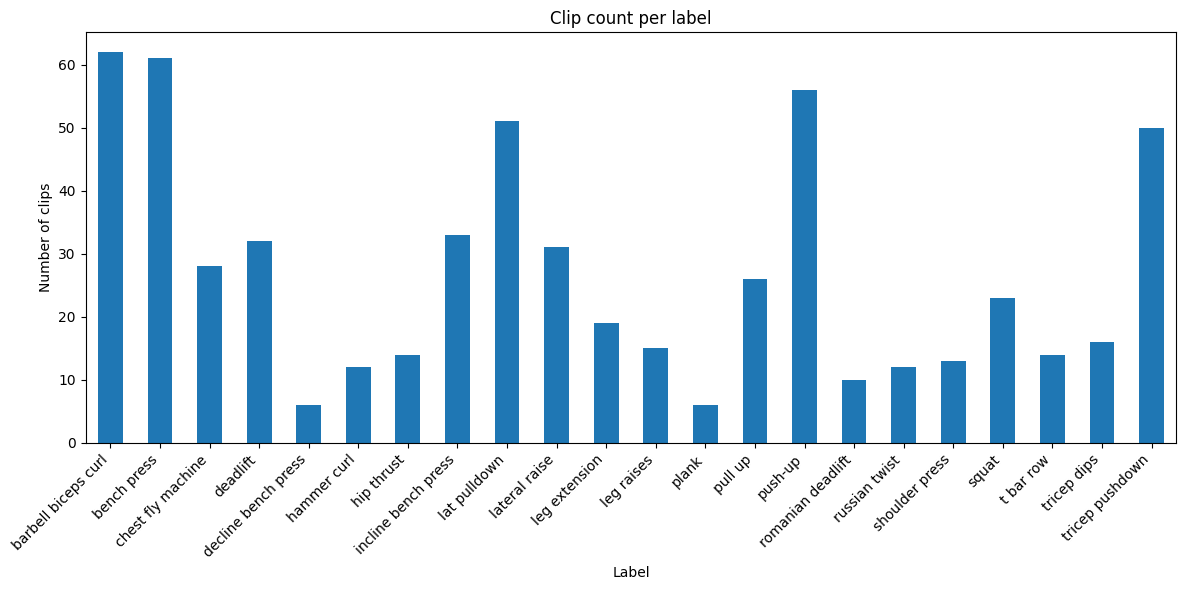

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# ----- count clips per label -----
counts = df["label"].value_counts().sort_index()   # Series: label → n

print("Clip-count per label:")
print(counts)

# ----- bar-plot -----
plt.figure(figsize=(12,6))
counts.plot(kind="bar")
plt.title("Clip count per label")
plt.xlabel("Label")
plt.ylabel("Number of clips")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Clip-count per label:
barbell biceps curl    62
bench press            61
push-up                56
lat pulldown           51
tricep Pushdown        50
incline bench press    33
deadlift               32
lateral raise          31
chest fly machine      28
pull Up                26
squat                  23
leg extension          19
tricep dips            16
leg raises             15
t bar row              14
hip thrust             14
shoulder press         13
hammer curl            12
russian twist          12
romanian deadlift      10
decline bench press     6
plank                   6
dtype: int64


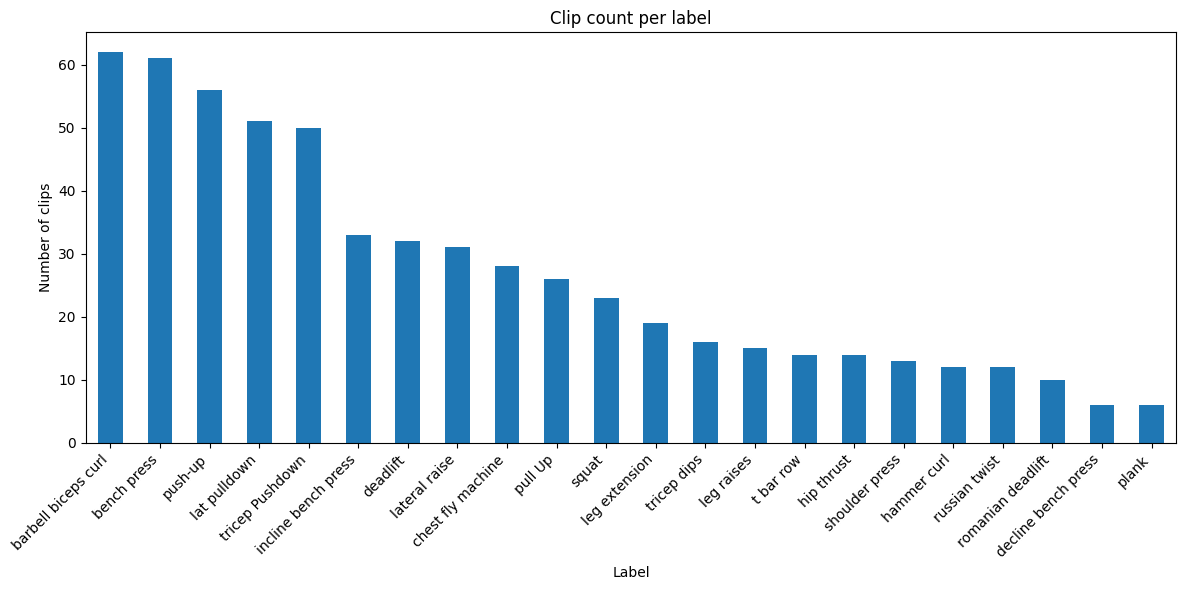

In [ ]:
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path(path)

# ----- gather counts -----
counts = Counter(p.parent.name for p in ROOT.glob("*/*.mp4"))
series  = pd.Series(counts).sort_values(ascending=False)

print("Clip-count per label:")
print(series)

# ----- bar-plot -----
plt.figure(figsize=(12,6))
series.plot(kind="bar")
plt.title("Clip count per label")
plt.xlabel("Label")
plt.ylabel("Number of clips")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import HTML
import random, pathlib

idxs  = random.sample(range(len(df)), 40)
cards = []

for idx in idxs:
    path  = df.at[idx, "filepath"]
    label = df.at[idx, "label"]

    mp4 = pathlib.Path(path).read_bytes()
    b64 = b64encode(mp4).decode()
    cards.append(f"""
      <div style="display:inline-block;margin:6px;text-align:center">
        <video width="240" controls loop muted>
          <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        </video><br>
        <span style="font-size:0.9em">{label}</span>
      </div>
    """)

HTML("<div style='white-space:nowrap'>" + "\n".join(cards) + "</div>")


In [ ]:
df['filepath']

filepath          label  \
0    /kaggle/input/workoutfitness-video/t bar row/t...      t bar row   
1    /kaggle/input/workoutfitness-video/lat pulldow...   lat pulldown   
2    /kaggle/input/workoutfitness-video/t bar row/t...      t bar row   
3    /kaggle/input/workoutfitness-video/leg extensi...  leg extension   
4    /kaggle/input/workoutfitness-video/hip thrust/...     hip thrust   
..                                                 ...            ...   
585  /kaggle/input/workoutfitness-video/bench press...    bench press   
586  /kaggle/input/workoutfitness-video/bench press...    bench press   
587  /kaggle/input/workoutfitness-video/lat pulldow...   lat pulldown   
588  /kaggle/input/workoutfitness-video/push-up/pus...        push-up   
589  /kaggle/input/workoutfitness-video/bench press...    bench press   

     bench_aux  label_idx          group_name  group_idx  
0           -1         19        barbell_pull          1  
1           -1          8  cable_machine_pull          3  
2           -1         19        barbell_pull          1  
3           -1         10     machine_leg_iso          7  
4           -1          6       barbell_lower          2  
..         ...        ...                 ...        ...  
585          0          1        bench_family          0  
586          0          1        bench_family          0  
587         -1          8  cable_machine_pull          3  
588         -1         14    bodyweight_upper          5  
589          0          1        bench_family          0  

[590 rows x 6 columns]

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


16 classes: ['bench press', 'bicep curl', 'chest fly machine', 'deadlift', 'hip thrust', 'lat pulling', 'lateral raise', 'leg extension', 'leg raises', 'push-up', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']
Pose masks will be generated on-the-fly during training/evaluation.


LR Loop:   0%|          | 0/2 [00:00<?, ?it/s]

WD Loop:   0%|          | 0/2 [00:00<?, ?it/s]


=== Config: B2_LR0.001_WD0 ===


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()



Epoch 1/8 Train:   0%|          | 0/234 [00:00<?, ?it/s]




Epoch 1/8 Train:   0%|          | 1/234 [00:14<56:49, 14.63s/it]




Epoch 1/8 Train:   1%|          | 2/234 [00:25<47:11, 12.20s/it]




Epoch 1/8 Train:   1%|▏         | 3/234 [00:33<40:48, 10.60s/it]




Epoch 1/8 Train:   2%|▏         | 4/234 [00:41<36:35,  9.54s/it]




Epoch 1/8 Train:   2%|▏         | 5/234 [00:53<39:39, 10.39s/it]




Epoch 1/8 Train:   3%|▎         | 6/234 [01:01<36:09,  9.52s/it]

Batch Size Loop:   0%|          | 0/2 [01:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=eeec0072797771fa759d85f7848e1a79c2703f83867ae5ae793430ebf51f9313
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=bec41623fecc73efdd9640ba90ec19e0b56a476a6cf5300609bf188eb53b846b
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.11/dist-packages/fvcore-0.1.5.post20221221.dist-info/top_level.txt' mode='r' encoding='utf-8'>
  for line in open(toplevel):
/usr/local/lib/python3.11/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.11/dist-packages/iopath-0.1.10.dist-info/top_level.txt' mode='r' encoding='utf-8'>
  for line in open(toplevel):
/usr/local/lib/python3.11/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.11/dist-packages/portalocker-3.1.1.dist-info/top_level.txt' mode='r' encoding='utf-8'>

In [ ]:
import os, random, warnings, cv2, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, sys

from pathlib import Path

from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import Resize

from tqdm import tqdm

import pandas as pd

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

# ----------------------------------------
# Suppress C++ logs and absl warnings
# ----------------------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GLOG_minloglevel"] = "2"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

# Context manager to suppress stderr from native libs
from contextlib import contextmanager
@contextmanager
def suppress_stderr():
    fd = sys.stderr.fileno()
    old_stderr = os.dup(fd)
    devnull = os.open(os.devnull, os.O_WRONLY)
    os.dup2(devnull, fd)
    try:
        yield
    finally:
        os.dup2(old_stderr, fd)
        os.close(devnull)
        os.close(old_stderr)

# Try import MediaPipe
try:
    import mediapipe as mp
    mp_pose = mp.solutions.pose
except ImportError:
    mp = None
    mp_pose = None
    print("Warning: mediapipe not installed, using zero masks.")

# ------------------------------
# 1. Global constants & seeds
# ------------------------------
warnings.filterwarnings("default")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATA_ROOT = Path(kagglehub.dataset_download("hasyimabdillah/workoutfitness-video"))
default_mask_dir = Path.cwd() / "pose_masks"
MASK_DIR = default_mask_dir
MASK_DIR.mkdir(parents=True, exist_ok=True)

MERGE = {"bench press":"bench press","incline bench press":"bench press",
         "decline bench press":"bench press","barbell biceps curl":"bicep curl",
         "hammer curl":"bicep curl","deadlift":"deadlift",
         "romanian deadlift":"deadlift","lat pulldown":"lat pulling",
         "pull up":"lat pulling"}
DROP = {"plank"}

MEAN, STD = (0.45,0.45,0.45), (0.225,0.225,0.225)
SIZE = 224
FRAMES = 32      # fast path length
ALPHA = 4        # slow = FRAMES/ALPHA
BATCHES = [2,4]
LRS = [1e-3,1e-4]
WEIGHT_DECAYS = [0,1e-2]
N_FOLDS = 5
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 2. Download & prepare DataFrame
# ------------------------------
recs=[]
for cls in DATA_ROOT.iterdir():
    if not cls.is_dir(): continue
    raw = cls.name.lower()
    if raw in DROP: continue
    lbl = MERGE.get(raw, raw)
    for mp4 in cls.glob("*.mp4"):
        recs.append({"filepath": str(mp4), "label": lbl})
df = pd.DataFrame(recs).sample(frac=1, random_state=SEED).reset_index(drop=True)
CLASSES = sorted(df.label.unique())
df["label_idx"] = df.label.map({c:i for i,c in enumerate(CLASSES)})
print(f"Initial {len(CLASSES)} classes:", CLASSES)
print(f"Initial dataset size: {len(df)} videos.")

# ------------------------------
# 3. Pose mask pre-extraction with error handling
# ------------------------------
def pose_to_mask(lm_xyz, size=SIZE, thick=2):
    edges=[(11,13),(13,15),(12,14),(14,16),(23,25),(25,27),(24,26),(26,28),
           (11,12),(23,24),(11,23),(12,24)]
    mask=np.zeros((size,size),np.float32)
    for a,b in edges:
        xa,ya=(lm_xyz[a,:2]*size).astype(int)
        xb,yb=(lm_xyz[b,:2]*size).astype(int)
        cv2.line(mask,(xa,ya),(xb,yb),1,thick,cv2.LINE_AA)
    return mask

print("Pre-extracting pose masks...")
problematic_files = set() # Set to store paths of problematic files

for path in tqdm(df.filepath.unique(), desc="Extracting Pose Masks"):
    stem = Path(path).stem
    mfile = MASK_DIR/(stem+".pt")

    if mfile.exists():
        # Optional: Verify existing file is not empty/corrupt if you suspect issues
        # For now, we assume if it exists, it's good from a previous run.
        continue

    cap = cv2.VideoCapture(path)
    if not cap.isOpened(): # Check if video file could be opened at all
        print(f"Error: Could not open video file {path}. Skipping mask extraction.")
        problematic_files.add(path)
        cap.release()
        continue

    tot = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if tot == 0: # Handle videos with zero frames
        print(f"Warning: Video {path} has 0 frames. Skipping mask extraction.")
        problematic_files.add(path)
        cap.release()
        continue

    masks = []

    # Use a flag to track if MediaPipe processing for this video failed
    mediapipe_failed_for_this_video = False

    if mp_pose is not None:
        try:
            with suppress_stderr():
                with mp_pose.Pose(static_image_mode=False, model_complexity=1) as pose:
                    for _ in range(tot):
                        ret, fr = cap.read()
                        if not ret:
                            # This usually indicates end of stream or a corrupt segment
                            print(f"Warning: Failed to read frame from {path}. Stopping frame processing for this video.")
                            break
                        img = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                        with suppress_stderr():
                            res = pose.process(img)
                        lm = np.array([[l.x, l.y, l.z] for l in res.pose_landmarks.landmark]) if res and res.pose_landmarks else np.zeros((33,3))
                        masks.append(torch.from_numpy(pose_to_mask(lm)).unsqueeze(0))
        except Exception as e:
            # Catch MediaPipe or underlying OpenCV errors during frame processing
            print(f"Error: MediaPipe processing failed for {path}. Using zero masks. Details: {e}")
            masks = [torch.zeros((1, SIZE, SIZE), dtype=torch.float32) for _ in range(tot)]
            mediapipe_failed_for_this_video = True
    else:
        # If MediaPipe is not installed, always use zero masks
        masks = [torch.zeros((1, SIZE, SIZE), dtype=torch.float32) for _ in range(tot)]
        mediapipe_failed_for_this_video = True # Mark as "failed" in the sense of no actual pose data

    cap.release()

    if len(masks) == 0:
        # If no masks could be generated for any reason (e.g., video was too short, read failed early)
        masks = [torch.zeros((1, SIZE, SIZE), dtype=torch.float32)] # Ensure at least one
        print(f"Warning: No valid masks generated for {path}. Defaulting to a single zero mask.")
        problematic_files.add(path) # Mark as problematic if no real masks were produced

    # Only add to problematic_files if an actual error occurred that led to using zero masks
    # or if the video couldn't be opened/had zero frames.
    if mediapipe_failed_for_this_video or not cap.isOpened() or tot == 0:
        problematic_files.add(path)

    masks_tensor = torch.stack(masks)  # [T,1,224,224]

    # ensure filename has no illegal chars and save
    safe_stem = Path(path).stem.replace(" ", "_").replace("(", "").replace(")", "") # Add more replacements if needed
    out_path = MASK_DIR / f"{safe_stem}.pt"

    try:
        with open(out_path, "wb") as f:
            torch.save(masks_tensor, f)
    except IOError as e:
        print(f"Error: Failed to save mask file {out_path}. Details: {e}")
        problematic_files.add(path) # Add to problematic if saving fails

print("Pose masks ready.")

# ------------------------------
# Filter out problematic files from DataFrame
# ------------------------------
initial_df_len = len(df)
df = df[~df['filepath'].isin(problematic_files)].reset_index(drop=True)
num_removed = initial_df_len - len(df)

if num_removed > 0:
    print(f"\nRemoved {num_removed} problematic videos from the dataset.")
    print("List of removed files (first 10 if many):")
    for i, p_file in enumerate(list(problematic_files)):
        if i >= 10:
            print("... and more.")
            break
        print(f"- {p_file}")
else:
    print("\nNo problematic videos were found and removed.")

# Re-create CLASSES and label_idx based on the filtered DataFrame
CLASSES = sorted(df.label.unique())
df["label_idx"] = df.label.map({c:i for i,c in enumerate(CLASSES)})
print(f"\nFinal {len(CLASSES)} classes after filtering: {CLASSES}")
print(f"Final dataset size: {len(df)} videos for training.")

# ------------------------------
# 4. Utils: pad/trim, rgb_transform, sampler
# ------------------------------
from torch.nn.functional import interpolate

def pad_or_trim(x, T=FRAMES):
    cur=x.shape[0]
    if cur < T:
        pad = x[-1:].repeat(T-cur,*([1]*(x.ndim-1)))
        return torch.cat([x, pad], dim=0)
    return x[:T]

def rgb_transform(video):
    video = interpolate(video, size=(SIZE,SIZE), mode='bilinear', align_corners=False)
    m = torch.tensor(MEAN).view(1,3,1,1).to(video.device)
    s = torch.tensor(STD).view(1,3,1,1).to(video.device)
    return (video - m) / s

def uniform_subsample(x, num_samples=FRAMES):
    # Ensure num_samples is not greater than x.shape[0]
    if x.shape[0] < num_samples:
        return x # Will be padded later by pad_or_trim
    idxs = torch.linspace(0, x.shape[0]-1, num_samples).long()
    return x[idxs]

# ------------------------------
# 5. Dataset & collate_fn
# ------------------------------
class FusionDS(Dataset):
    def __init__(self, df): self.df=df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        p = self.df.iloc[i].filepath
        # Now we are confident that the mask file exists because problematic videos were filtered
        stem = Path(p).stem.replace(" ", "_").replace("(", "").replace(")", "") # Use same safe_stem as in pre-extraction
        mask_all = torch.load(MASK_DIR/(stem+".pt"))

        # Ensure mask_all has enough frames for subsampling before padding/trimming
        # If a video was problematic and only got a single zero mask, uniform_subsample will handle it gracefully.
        mask = uniform_subsample(mask_all)
        mask = pad_or_trim(mask) # Ensure mask is of correct length FRAMES

        cap = cv2.VideoCapture(p)
        # We assume cap.isOpened() would be true here due to filtering, but
        # defensive check is good practice. This part was NOT the problem.
        if not cap.isOpened():
            print(f"Error: Video {p} (previously deemed good) could not be opened during __getitem__. Returning zero data.")
            # This should ideally not happen if filtering was perfect.
            video = torch.zeros((FRAMES, 3, SIZE, SIZE), dtype=torch.float32)
            fusion = torch.cat([video, mask], 1)
            fast = fusion; slow = fusion[::ALPHA]
            fast = fast.permute(1,0,2,3); slow = slow.permute(1,0,2,3)
            label = torch.tensor(self.df.label_idx[i])
            return [slow, fast], label

        tot = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []
        # Sample video frames (same logic as mask_all subsampling)
        # Using index list from mask_all if it exists, otherwise regenerate for video
        idxs = torch.linspace(0, tot-1, FRAMES).long().tolist() if tot >= FRAMES else list(range(tot))

        for j in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, float(j))
            ret, fr = cap.read()
            img_np = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB) if ret else np.zeros((SIZE,SIZE,3),np.uint8)
            frames.append(torch.from_numpy(img_np).permute(2,0,1).float()/255.)
        cap.release()

        video = torch.stack(frames)
        video = pad_or_trim(video)
        video = rgb_transform(video)

        # Ensure mask and video have the same number of temporal frames before concatenation
        # This is handled by pad_or_trim on both
        fusion = torch.cat([video, mask], 1) # Concatenate along channel dimension

        fast = fusion; slow = fusion[::ALPHA]
        fast = fast.permute(1,0,2,3); slow = slow.permute(1,0,2,3)
        label = torch.tensor(self.df.label_idx[i])
        return [slow, fast], label

def collate_fn(batch):
    slow_b = torch.stack([x[0][0] for x in batch])
    fast_b = torch.stack([x[0][1] for x in batch])
    labels = torch.stack([x[1] for x in batch])
    return [slow_b, fast_b], labels

# ------------------------------
# 6. Model builder via torch.hub
# ------------------------------
def build_model(n_cls):
    model = torch.hub.load('facebookresearch/pytorchvideo','slowfast_r50',pretrained=True)
    # The original model expects 3 input channels. We need 4 (RGB + Mask).
    # We modify the first convolutional layer in both pathways.
    for idx in [0,1]: # 0 for slow pathway, 1 for fast pathway
        old = model.blocks[0].multipathway_blocks[idx].conv
        new = nn.Conv3d(4, old.out_channels, old.kernel_size, old.stride, old.padding, bias=False)
        with torch.no_grad():
            new.weight[:,:3]=old.weight # Copy RGB weights
            new.weight[:,3]=old.weight.mean(1) # Initialize mask channel with mean of RGB weights
        model.blocks[0].multipathway_blocks[idx].conv=new
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, n_cls)
    return model.to(DEVICE)

# ------------------------------
# 7. Training + eval + hyper-search
# ------------------------------
kf = StratifiedKFold(N_FOLDS, shuffle=True, random_state=SEED)
results=[]
writer = SummaryWriter(log_dir="runs/slowfast_full")

for B in tqdm(BATCHES, desc="Batch Size Loop"):
    for LR in tqdm(LRS, desc="LR Loop"):
        for WD in tqdm(WEIGHT_DECAYS, desc="WD Loop"):
            cfg = f"B{B}_LR{LR}_WD{WD}"
            print(f"\n=== Config: {cfg} ===")
            fold_accs=[]
            # Use df.label_idx for stratification after problematic files are removed
            for f, (tr, vl) in enumerate(kf.split(df, df.label_idx),1):
                print(f"--- Fold {f}/{N_FOLDS} ---")
                ds_tr = FusionDS(df.iloc[tr]); ds_vl = FusionDS(df.iloc[vl])
                dl_tr = DataLoader(ds_tr, batch_size=B, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
                dl_vl = DataLoader(ds_vl, batch_size=B, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
                model = build_model(len(CLASSES))
                opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
                sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, steps_per_epoch=len(dl_tr), epochs=EPOCHS)

                # Freeze backbone for first few epochs (as in your original code)
                for p in model.blocks[:-1].parameters(): p.requires_grad=False

                best_acc=0
                for ep in range(EPOCHS):
                    # Unfreeze and potentially adjust LR after epoch 3
                    if ep==3:
                        for p in model.parameters(): p.requires_grad=True
                        # Optionally, change optimizer or lower LR here if desired for fine-tuning
                        opt = torch.optim.AdamW(model.parameters(), lr=LR/10, weight_decay=WD) # Smaller LR for fine-tuning
                        sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR/10, steps_per_epoch=len(dl_tr), epochs=EPOCHS-ep) # Reset scheduler for remaining epochs
                        print(f"Unfreezing model and setting LR to {LR/10} at epoch {ep}.")

                    model.train()
                    train_loss_sum = 0
                    for step,(x,y) in enumerate(dl_tr):
                        x = [x[0].to(DEVICE), x[1].to(DEVICE)]; y = y.to(DEVICE)
                        opt.zero_grad(); out=model(x)
                        loss=nn.functional.cross_entropy(out,y,label_smoothing=0.1)
                        loss.backward(); opt.step(); sched.step()
                        train_loss_sum += loss.item()
                        writer.add_scalar(f"{cfg}/fold{f}/train/loss", loss.item(), ep*len(dl_tr)+step)
                    avg_train_loss = train_loss_sum / len(dl_tr)
                    print(f"Epoch {ep+1}/{EPOCHS} Train Loss: {avg_train_loss:.4f}")

                    model.eval()
                    y_true,y_pred=[],[]
                    val_loss_sum = 0
                    with torch.no_grad():
                        for x,y in dl_vl:
                            x=[x[0].to(DEVICE), x[1].to(DEVICE)]; y=y.to(DEVICE)
                            out = model(x)
                            pred=out.argmax(1)
                            val_loss = nn.functional.cross_entropy(out, y) # No label smoothing for validation loss
                            val_loss_sum += val_loss.item()
                            y_true+=y.cpu().tolist(); y_pred+=pred.cpu().tolist()

                    acc=(np.array(y_true)==np.array(y_pred)).mean()
                    avg_val_loss = val_loss_sum / len(dl_vl)
                    writer.add_scalar(f"{cfg}/fold{f}/val/acc", acc, ep)
                    writer.add_scalar(f"{cfg}/fold{f}/val/loss", avg_val_loss, ep)

                    if acc > best_acc:
                        best_acc = acc
                        # Optional: Save best model checkpoint here
                        # torch.save(model.state_dict(), f"best_model_{cfg}_fold{f}.pth")
                    print(f"Epoch {ep+1}/{EPOCHS} Val Acc: {acc:.3f} | Best Acc: {best_acc:.3f}")

                print(f"Fold {f} best acc: {best_acc:.3f}")
                # Print classification report and confusion matrix for the last epoch's validation
                print("Classification Report (Last Epoch):")
                print(classification_report(y_true, y_pred, target_names=CLASSES))
                cm=confusion_matrix(y_true, y_pred)
                fig, ax = plt.subplots(figsize=(10, 8)) # Larger figure for readability
                cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues); ax.set_title(f"CM {cfg} fold{f}")
                plt.colorbar(cax)
                tick_marks = np.arange(len(CLASSES))
                plt.xticks(tick_marks, CLASSES, rotation=90)
                plt.yticks(tick_marks, CLASSES)
                plt.ylabel('True label')
                plt.xlabel('Predicted label')
                plt.tight_layout()
                writer.add_figure(f"{cfg}/fold{f}/conf_matrix", fig)
                plt.close(fig) # Close the figure to free up memory

                fold_accs.append(best_acc)
            mean_acc=np.mean(fold_accs)
            results.append((cfg, mean_acc))
            print(f"Config {cfg} mean acc: {mean_acc:.3f}\n")

print("=== All configs results ===")
for cfg, acc in results:
    print(f"{cfg}: {acc:.3f}")
writer.close()

Initial 16 classes: ['bench press', 'bicep curl', 'chest fly machine', 'deadlift', 'hip thrust', 'lat pulling', 'lateral raise', 'leg extension', 'leg raises', 'push-up', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']
Initial dataset size: 584 videos.
Pre-extracting pose masks...


Extracting Pose Masks:   0%|          | 0/584 [00:00<?, ?it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/barbell biceps curl/barbell biceps curl_22.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   0%|          | 1/584 [00:00<02:56,  3.31it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/lateral raise/lateral raise_32.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   1%|          | 3/584 [00:01<04:36,  2.10it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/tricep Pushdown/tricep pushdown_33.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   1%|          | 4/584 [00:01<04:13,  2.29it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/lat pulldown/lat pulldown_33.mp4. Using zero masks. Details: fileno
Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/incline bench press/incline bench press_32.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   1%|          | 7/584 [00:07<10:38,  1.11s/it]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/chest fly machine/chest fly machine_18.mp4. Using zero masks. Details: fileno
Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/chest fly machine/chest fly machine_28.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   2%|▏         | 10/584 [00:07<05:10,  1.85it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/barbell biceps curl/barbell biceps curl_23.mp4. Using zero masks. Details: fileno
Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/leg extension/leg extension_21.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   2%|▏         | 11/584 [00:07<04:24,  2.17it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/tricep Pushdown/tricep pushdown_26.mp4. Using zero masks. Details: fileno
Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/romanian deadlift/romanian deadlift_13.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   2%|▏         | 13/584 [00:08<03:20,  2.85it/s]

Error: MediaPipe processing failed for /kaggle/input/workoutfitness-video/bench press/bench press_40.mp4. Using zero masks. Details: fileno


Extracting Pose Masks:   2%|▏         | 13/584 [00:11<08:11,  1.16it/s]


RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 448 vs 342

In [ ]:
# =========================================
#  Workout/Fitness Video Classifier (SlowFast-4ch)
#  Single-cell, end-to-end pipeline
# =========================================
# Author: ChatGPT
# -----------------------------------------
# 1. Imports & global constants
# -----------------------------------------
import os, copy, random, warnings, cv2, numpy as np, torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize # spatial
from pytorchvideo.transforms import UniformTemporalSubsample # temporal
import mediapipe as mp
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import kagglehub

warnings.filterwarnings("ignore")
SEED      = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -----------------------------------------
# 2. Download dataset from Kaggle
# -----------------------------------------
DATASET_ROOT  = Path(kagglehub.dataset_download("hasyimabdillah/workoutfitness-video"))
print("Dataset root:", DATASET_ROOT)

MERGE = {  # class merging
    "bench press":"bench press","incline bench press":"bench press",
    "decline bench press":"bench press","barbell biceps curl":"bicep curl",
    "hammer curl":"bicep curl","deadlift":"deadlift",
    "romanian deadlift":"deadlift","lat pulldown":"lat pulling",
    "pull up":"lat pulling",
}
DROP  = {"plank"}

recs=[]
for cls_dir in DATASET_ROOT.iterdir():
    if not cls_dir.is_dir(): continue
    raw = cls_dir.name.lower()
    if raw in DROP: continue
    label = MERGE.get(raw, raw)
    for mp4 in cls_dir.glob("*.mp4"):
        recs.append({"filepath": str(mp4), "label": label, "raw": raw})
df = pd.DataFrame(recs).sample(frac=1, random_state=SEED).reset_index(drop=True)
CLASSES = sorted(df.label.unique())
label2id = {c:i for i,c in enumerate(CLASSES)}
df["label_idx"] = df.label.map(label2id)
print(f"{len(CLASSES)} classes:", CLASSES)

# -----------------------------------------
# 3. Pose processing helpers
# -----------------------------------------
mp_pose = mp.solutions.pose

def pose_to_mask(lm_xyz, size=224, thick=2):
    """Draw simple skeleton mask from 33 normalized landmarks."""
    edges = [(11,13),(13,15),(12,14),(14,16),
             (23,25),(25,27),(24,26),(26,28),
             (11,12),(23,24),(11,23),(12,24)]
    mask = np.zeros((size,size), np.float32)
    for a,b in edges:
        xa,ya = (lm_xyz[a,:2]*size).astype(int)
        xb,yb = (lm_xyz[b,:2]*size).astype(int)
        cv2.line(mask,(xa,ya),(xb,yb),1,thick,cv2.LINE_AA)
    return mask

# -----------------------------------------
# 4. Video + mask transform (resize + normalize)
# -----------------------------------------
MEAN, STD = (0.45,0.45,0.45), (0.225,0.225,0.225)
SIZE      = 224

def rgb_transform(video):        # video: [T,3,H,W], float32 0-1
    video = torch.nn.functional.interpolate(
        video, size=(SIZE,SIZE), mode='bilinear', align_corners=False
    )                                 # keeps shape [T,3,H,W]
    mean = torch.tensor(MEAN).view(1,3,1,1).to(video.device)
    std  = torch.tensor(STD).view(1,3,1,1).to(video.device)
    return (video - mean) / std

# -----------------------------------------
# 5. Dataset that outputs SlowFast pathways
# -----------------------------------------
SUBSMP, FRAMES = 32, 32           # sample 32 frames per video

TARGET_T = 32     # fast-path length
ALPHA     = 4     # slow/fast ratio  (slow = 32/4 = 8)

def pad_or_trim(x, T=TARGET_T):
    """Make sure x.shape[0] == T (first dim = time)."""
    cur = x.shape[0]
    if cur == T:      # מושלם
        return x
    if cur < T:        # padding – שחפל את הפריים האחרון
        pad = x[-1:].repeat(T - cur, *([1] * (x.ndim - 1)))
        return torch.cat([x, pad], dim=0)
    else:              # too long – גזור
        return x[:T]


class FusionDS(Dataset):
    def __init__(self, frame_df):
        self.df = frame_df.reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        vid_path = self.df.iloc[idx].filepath
        cap      = cv2.VideoCapture(vid_path)
        frames, masks = [], []
        tot = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        idxs = np.linspace(0, tot-1, FRAMES, dtype=int)

        with mp_pose.Pose(static_image_mode=False, model_complexity=1) as pose:
            for j in range(tot):
                ret, fr = cap.read()
                if not ret: break
                if j in idxs:
                    img = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                    res = pose.process(img)
                    if res.pose_landmarks:
                        lm = np.array([[l.x,l.y,l.z] for l in res.pose_landmarks.landmark])
                    else:
                        lm = np.zeros((33,3))
                    mask = pose_to_mask(lm)
                    fr_t = torch.from_numpy(img).permute(2,0,1).float()/255. # [3,H,W]
                    frames.append(fr_t)
                    masks.append(torch.from_numpy(mask).unsqueeze(0))         # [1,H,W]

        cap.release()


        video = torch.stack(frames)            # [t,3,h,w]  (t≤32)
        mask  = torch.stack(masks)             # [t,1,h,w]

        video = pad_or_trim(video)
        mask  = pad_or_trim(mask)

        video = rgb_transform(video)           # resize+normalize
        fusion= torch.cat([video, mask], 1)    # [32,4,224,224]

        # -------- SlowFast pathways --------
        fast = fusion                          # full rate
        slow = fusion[::ALPHA]                 # 8 פריימים מובטחים

        # permute to [C,T,H,W]
        fast = fast.permute(1,0,2,3)
        slow = slow.permute(1,0,2,3)

        label = torch.tensor(self.df.label_idx[idx])
        return [slow, fast], label

# -----------------------------------------
# 6. Collate fn (handles list inputs)
# -----------------------------------------
def collate_fn(batch):
    slow_batch = torch.stack([item[0][0] for item in batch])  # [B,C,T/4,H,W]
    fast_batch = torch.stack([item[0][1] for item in batch])  # [B,C,T,H,W]
    labels     = torch.stack([item[1]      for item in batch])
    return [slow_batch, fast_batch], labels

# -----------------------------------------
# 7. Build 4-channel SlowFast-R50
# -----------------------------------------
from pytorchvideo.models.hub import slowfast_r50

def build_slowfast_4ch(num_classes):
    model = slowfast_r50(pretrained=True)

    # modify first conv in slow pathway
    old_slow = model.blocks[0].multipathway_blocks[0].conv
    slow_conv = nn.Conv3d(4, old_slow.out_channels, old_slow.kernel_size,
                          old_slow.stride, old_slow.padding, bias=False)
    with torch.no_grad():
        slow_conv.weight[:, :3] = old_slow.weight
        slow_conv.weight[:, 3]  = old_slow.weight.mean(1)
    model.blocks[0].multipathway_blocks[0].conv = slow_conv

    # modify first conv in fast pathway
    old_fast = model.blocks[0].multipathway_blocks[1].conv
    fast_conv = nn.Conv3d(4, old_fast.out_channels, old_fast.kernel_size,
                          old_fast.stride, old_fast.padding, bias=False)
    with torch.no_grad():
        fast_conv.weight[:, :3] = old_fast.weight
        fast_conv.weight[:, 3]  = old_fast.weight.mean(1)
    model.blocks[0].multipathway_blocks[1].conv = fast_conv

    # modify classifier head
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, num_classes)
    return model

# -----------------------------------------
# 8. Training & evaluation utilities (modified for full dataset training)
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH, LR, EPOCHS = 4, 1e-4, 8 # N_FOLDS is removed as we are not doing folds

def train_full_dataset():
    train_ds = FusionDS(df) # Use the entire DataFrame for training
    train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)

    model = build_slowfast_4ch(len(CLASSES)).to(device)
    opt   = optim.AdamW(model.parameters(), LR)

    # freeze backbone for first 3 epochs
    for p in model.blocks[:-1].parameters():
        p.requires_grad = False

    for ep in range(EPOCHS):
        if ep == 3:  # unfreeze & lower LR
            for p in model.parameters(): p.requires_grad = True
            opt = optim.AdamW(model.parameters(), LR/10)

        # -------- training --------
        model.train()
        total_loss = 0
        correct = total = 0
        for batch_idx, (x, y) in enumerate(train_dl):
            x = [x[0].to(device), x[1].to(device)]
            y = y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss   = nn.functional.cross_entropy(logits, y, label_smoothing=0.1)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

            if (batch_idx + 1) % 50 == 0: # Print loss every 50 batches
                print(f"Epoch {ep+1}/{EPOCHS}, Batch {batch_idx+1}/{len(train_dl)} | Loss: {loss.item():.4f}")

        epoch_avg_loss = total_loss / len(train_dl)
        epoch_acc = correct / total
        print(f"Epoch {ep+1}/{EPOCHS} | Train Loss = {epoch_avg_loss:.4f} | Train Acc = {epoch_acc:.3f}")

    print("\nTraining on full dataset complete!")
    return model # Optionally return the trained model

# -----------------------------------------
# 9. Train on all data
# -----------------------------------------
print("\n===== Training on the entire dataset =====")
trained_model = train_full_dataset()

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

In [ ]:
# %%
!sudo apt install libavdevice-dev libavfilter-dev libavformat-dev libavcodec-dev libavutil-dev
!apt install -y ffmpeg
!pip install av
# %%
# Upgrade torch and torchvision to a recent version that includes functional_tensor
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118 # Use cu118 for CUDA 11.8
# We can keep mediapipe and opencv-python as they were
!pip install mediapipe opencv-python
# %%
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasyimabdillah/workoutfitness-video")

print("Path to dataset files:", path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libavcodec-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavdevice-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavfilter-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavformat-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavutil-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Path to dataset files: /kaggle/input/workoutfitness-video


In [ ]:
# =========================================
#  Workout/Fitness Video Classifier (SlowFast-4ch)
#  Single-cell, end-to-end pipeline - Optimized for Speed
# =========================================
# Author: ChatGPT (with improvements)
# -----------------------------------------
# 1. Imports & global constants
# -----------------------------------------
import os, copy, random, warnings, cv2, numpy as np, torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize # spatial
from pytorchvideo.transforms import UniformTemporalSubsample # temporal
import mediapipe as mp
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold # Still imported but not used for training
import kagglehub
import time # For timing operations

warnings.filterwarnings("ignore")
SEED      = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Global constants for transformations and model
MEAN, STD = (0.45,0.45,0.45), (0.225,0.225,0.225)
SIZE      = 224 # Target spatial size
SUBSMP, FRAMES = 32, 32 # Number of frames to sample from video

TARGET_T = 32     # fast-path length (same as FRAMES)
ALPHA     = 4     # slow/fast ratio (slow = TARGET_T / ALPHA = 32/4 = 8 frames)

# -----------------------------------------
# 2. Download dataset from Kaggle
# -----------------------------------------
DATASET_ROOT  = Path(kagglehub.dataset_download("hasyimabdillah/workoutfitness-video"))
print("Dataset root:", DATASET_ROOT)

MERGE = {  # class merging
    "bench press":"bench press","incline bench press":"bench press",
    "decline bench press":"bench press","barbell biceps curl":"bicep curl",
    "hammer curl":"bicep curl","deadlift":"deadlift",
    "romanian deadlift":"deadlift","lat pulldown":"lat pulling",
    "pull up":"lat pulling",
}
DROP  = {"plank"}

recs=[]
for cls_dir in DATASET_ROOT.iterdir():
    if not cls_dir.is_dir(): continue
    raw = cls_dir.name.lower()
    if raw in DROP: continue
    label = MERGE.get(raw, raw)
    for mp4 in cls_dir.glob("*.mp4"):
        recs.append({"filepath": str(mp4), "label": label, "raw": raw})
df = pd.DataFrame(recs).sample(frac=1, random_state=SEED).reset_index(drop=True)
CLASSES = sorted(df.label.unique())
label2id = {c:i for i,c in enumerate(CLASSES)}
df["label_idx"] = df.label.map(label2id)
print(f"{len(CLASSES)} classes:", CLASSES)
print(f"Total videos in dataset: {len(df)}")


# -----------------------------------------
# 3. Pose processing helpers
# -----------------------------------------
mp_pose = mp.solutions.pose

def pose_to_mask(lm_xyz, size=224, thick=2):
    """Draw simple skeleton mask from 33 normalized landmarks."""
    edges = [(11,13),(13,15),(12,14),(14,16),
             (23,25),(25,27),(24,26),(26,28),
             (11,12),(23,24),(11,23),(12,24)]
    mask = np.zeros((size,size), np.float32)
    for a,b in edges:
        xa,ya = (lm_xyz[a,:2]*size).astype(int)
        xb,yb = (lm_xyz[b,:2]*size).astype(int)
        cv2.line(mask,(xa,ya),(xb,yb),1,thick,cv2.LINE_AA)
    return mask

# -----------------------------------------
# 4. Video + mask transform (resize + normalize)
# -----------------------------------------
def rgb_transform(video):        # video: [T,3,H,W], float32 0-1
    # Interpolate already happens in __getitem__ for the new FusionDS
    # or during preprocessing. This function now only handles normalization.
    mean = torch.tensor(MEAN).view(1,3,1,1).to(video.device)
    std  = torch.tensor(STD).view(1,3,1,1).to(video.device)
    return (video - mean) / std

def pad_or_trim(x, T=TARGET_T):
    """Make sure x.shape[0] == T (first dim = time)."""
    cur = x.shape[0]
    if cur == T:
        return x
    if cur < T:
        pad = x[-1:].repeat(T - cur, *([1] * (x.ndim - 1)))
        return torch.cat([x, pad], dim=0)
    else:
        return x[:T]

# -----------------------------------------
# 5. Preprocessing Script (Run this ONCE)
# -----------------------------------------
PREPROCESSED_DIR = Path("preprocessed_videos")
PREPROCESSED_DIR.mkdir(exist_ok=True)

df_preprocessed_records = []
print("\n===== Starting Preprocessing =====")
start_time = time.time()

# MediaPipe Pose needs to be initialized ONCE per process for efficiency
with mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for idx, row in df.iterrows():
        vid_path = Path(row.filepath)
        output_rgb_path = PREPROCESSED_DIR / f"{vid_path.stem}_rgb.pt"
        output_mask_path = PREPROCESSED_DIR / f"{vid_path.stem}_mask.pt"

        # Check if already processed to avoid redundant computation
        if output_rgb_path.exists() and output_mask_path.exists():
            df_preprocessed_records.append({
                "filepath": str(vid_path), # Keep original for reference
                "processed_rgb_path": str(output_rgb_path),
                "processed_mask_path": str(output_mask_path),
                "label": row.label,
                "label_idx": row.label_idx
            })
            continue # Skip to next video

        cap = cv2.VideoCapture(str(vid_path))
        if not cap.isOpened():
            print(f"Warning: Could not open video {vid_path.name}. Skipping.")
            continue

        frames_list, masks_list = [], []
        tot_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # Select target frames using linspace, ensuring valid indices
        idxs_to_sample = np.linspace(0, tot_frames - 1, FRAMES, dtype=int)

        current_frame_idx = 0
        sampled_count = 0
        while True:
            ret, fr = cap.read()
            if not ret:
                break # End of video

            if current_frame_idx in idxs_to_sample:
                # Convert to RGB for MediaPipe
                img = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)

                # Perform pose estimation
                res = pose.process(img)

                # Extract landmarks or create an empty mask if no landmarks detected
                if res.pose_landmarks:
                    lm = np.array([[l.x,l.y,l.z] for l in res.pose_landmarks.landmark])
                else:
                    lm = np.zeros((33,3)) # Fallback to zeros if no pose detected

                # Generate mask and convert frame to tensor
                mask = pose_to_mask(lm, size=SIZE) # Apply SIZE here for consistency
                # Convert img to tensor and normalize to 0-1 range
                fr_t = torch.from_numpy(img).permute(2,0,1).float()/255.
                # Resize the RGB frame here as well
                fr_t = Resize((SIZE, SIZE))(fr_t)

                frames_list.append(fr_t)
                masks_list.append(torch.from_numpy(mask).unsqueeze(0)) # [1,H,W]
                sampled_count += 1

            current_frame_idx += 1
            if sampled_count >= FRAMES: # Stop once we have enough frames
                break

        cap.release()

        # Handle cases where video might have fewer than FRAMES sampled frames
        if len(frames_list) == 0:
            print(f"Warning: No frames or poses processed for {vid_path.name}. Skipping.")
            continue # Skip this video if no valid data

        video_tensor = torch.stack(frames_list)
        mask_tensor  = torch.stack(masks_list)

        # Pad or trim to ensure consistent length TARGET_T (FRAMES)
        video_tensor = pad_or_trim(video_tensor, T=TARGET_T)
        mask_tensor  = pad_or_trim(mask_tensor, T=TARGET_T)

        # Save the preprocessed tensors
        torch.save(video_tensor, output_rgb_path)
        torch.save(mask_tensor, output_mask_path)

        df_preprocessed_records.append({
            "filepath": str(vid_path), # Keep original for reference
            "processed_rgb_path": str(output_rgb_path),
            "processed_mask_path": str(output_mask_path),
            "label": row.label,
            "label_idx": row.label_idx
        })
        if (idx + 1) % 10 == 0:
             print(f"Processed {idx + 1}/{len(df)} videos. Current: {vid_path.name}")

# Create the new DataFrame for the Dataset
df_preprocessed = pd.DataFrame(df_preprocessed_records)
end_time = time.time()
print(f"\nPreprocessing complete! Processed {len(df_preprocessed)} videos in {end_time - start_time:.2f} seconds.")
print("Updated DataFrame for Dataset:")
print(df_preprocessed.head())


# -----------------------------------------
# 6. Optimized Dataset that loads preprocessed data
# -----------------------------------------
class FusionDS(Dataset):
    def __init__(self, frame_df):
        self.df = frame_df.reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        # Load preprocessed tensors directly from disk
        video = torch.load(self.df.iloc[idx].processed_rgb_path) # [T,3,H,W]
        mask  = torch.load(self.df.iloc[idx].processed_mask_path) # [T,1,H,W]

        # Apply RGB normalization (spatial resizing already happened in preprocessing)
        video = rgb_transform(video.to(device)) # Move to device early if possible for normalization
        # Note: mask is already 0-1 from pose_to_mask, no further normalization needed for it.

        fusion = torch.cat([video, mask], 1) # [T,4,H,W]

        # -------- SlowFast pathways --------
        fast = fusion                          # full rate
        slow = fusion[::ALPHA]                 # slow rate (e.g., 8 frames)

        # permute to [C,T,H,W]
        fast = fast.permute(1,0,2,3)
        slow = slow.permute(1,0,2,3)

        label = torch.tensor(self.df.label_idx[idx])
        return [slow, fast], label

# -----------------------------------------
# 7. Collate fn (handles list inputs)
# -----------------------------------------
def collate_fn(batch):
    slow_batch = torch.stack([item[0][0] for item in batch])  # [B,C,T/4,H,W]
    fast_batch = torch.stack([item[0][1] for item in batch])  # [B,C,T,H,W]
    labels     = torch.stack([item[1]      for item in batch])
    return [slow_batch, fast_batch], labels

# -----------------------------------------
# 8. Build 4-channel SlowFast-R50
# -----------------------------------------
from pytorchvideo.models.hub import slowfast_r50

def build_slowfast_4ch(num_classes):
    model = slowfast_r50(pretrained=True)

    # modify first conv in slow pathway
    old_slow = model.blocks[0].multipathway_blocks[0].conv
    slow_conv = nn.Conv3d(4, old_slow.out_channels, old_slow.kernel_size,
                          old_slow.stride, old_slow.padding, bias=False)
    with torch.no_grad():
        # Copy original weights for RGB channels
        slow_conv.weight[:, :3] = old_slow.weight
        # Initialize the 4th channel (mask) by averaging the original RGB channel weights
        slow_conv.weight[:, 3]  = old_slow.weight.mean(1)
    model.blocks[0].multipathway_blocks[0].conv = slow_conv

    # modify first conv in fast pathway
    old_fast = model.blocks[0].multipathway_blocks[1].conv
    fast_conv = nn.Conv3d(4, old_fast.out_channels, old_fast.kernel_size,
                          old_fast.stride, old_fast.padding, bias=False)
    with torch.no_grad():
        # Copy original weights for RGB channels
        fast_conv.weight[:, :3] = old_fast.weight
        # Initialize the 4th channel (mask) by averaging the original RGB channel weights
        fast_conv.weight[:, 3]  = old_fast.weight.mean(1)
    model.blocks[0].multipathway_blocks[1].conv = fast_conv

    # modify classifier head
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, num_classes)
    return model

# -----------------------------------------
# 9. Training utilities (modified for full dataset training)
# -----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 8 # Increased batch size
LR = 1e-4
EPOCHS = 8

def train_full_dataset():
    # Use the preprocessed DataFrame for training
    train_ds = FusionDS(df_preprocessed)
    train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=os.cpu_count() // 2 if os.cpu_count() else 4, # Use half of CPU cores, or 4 if not detected
                          pin_memory=True, collate_fn=collate_fn)
    print(f"Using {train_dl.num_workers} workers for DataLoader.")

    model = build_slowfast_4ch(len(CLASSES)).to(device)
    opt   = optim.AdamW(model.parameters(), LR)

    # freeze backbone for first 3 epochs
    for p in model.blocks[:-1].parameters():
        p.requires_grad = False

    print("\n===== Starting Training =====")
    for ep in range(EPOCHS):
        if ep == 3:  # unfreeze & lower LR
            print(f"Epoch {ep+1}: Unfreezing backbone and lowering LR to {LR/10:.1e}")
            for p in model.parameters(): p.requires_grad = True
            opt = optim.AdamW(model.parameters(), LR/10)

        # -------- training --------
        model.train()
        total_loss = 0
        correct = total = 0
        epoch_start_time = time.time()

        for batch_idx, (x, y) in enumerate(train_dl):
            # Inputs are already on device if rgb_transform moves them, or move here
            # x = [x[0].to(device), x[1].to(device)] # No need if done in Dataset's __getitem__
            y = y.to(device) # Labels still need to be moved

            opt.zero_grad()
            logits = model(x)
            loss   = nn.functional.cross_entropy(logits, y, label_smoothing=0.1)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch {ep+1}/{EPOCHS}, Batch {batch_idx+1}/{len(train_dl)} | Loss: {loss.item():.4f}")

        epoch_avg_loss = total_loss / len(train_dl)
        epoch_acc = correct / total
        epoch_end_time = time.time()
        print(f"Epoch {ep+1}/{EPOCHS} | Train Loss = {epoch_avg_loss:.4f} | Train Acc = {epoch_acc:.3f} | Time: {epoch_end_time - epoch_start_time:.2f}s")

    print("\nTraining on full dataset complete!")
    return model # Return the trained model

# -----------------------------------------
# 10. Train on all data
# -----------------------------------------
if len(df_preprocessed) > 0: # Only train if preprocessing was successful
    trained_model = train_full_dataset()
else:
    print("No preprocessed videos found. Cannot start training.")


# -----------------------------------------
# 11. Save the Trained Model
# -----------------------------------------
MODEL_SAVE_PATH = "slowfast_4ch_workout_classifier.pth"

if 'trained_model' in locals() and trained_model is not None:
    torch.save(trained_model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved successfully to {MODEL_SAVE_PATH}")
else:
    print("Error: `trained_model` is not defined or is None. Training might have failed.")

# -----------------------------------------
# 12. Load Model and Run Inference on a Random Video
# -----------------------------------------
MODEL_LOAD_PATH = "slowfast_4ch_workout_classifier.pth"

# Load the model architecture
loaded_model = build_slowfast_4ch(len(CLASSES)).to(device)

# Load the saved state dictionary
try:
    loaded_model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_location=device))
    loaded_model.eval() # Set the model to evaluation mode
    print(f"\nModel loaded successfully from {MODEL_LOAD_PATH} for inference.")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_LOAD_PATH}. Please ensure you saved the model.")
    # You might want to exit or handle this more robustly if inference is critical
    exit()

# Select a random video from the PREPROCESSED DataFrame for inference
if len(df_preprocessed) > 0:
    random_video_idx = random.randint(0, len(df_preprocessed) - 1)
    sample_record = df_preprocessed.iloc[random_video_idx]
    sample_filepath = sample_record.filepath # Original filepath
    sample_true_label = sample_record.label
    sample_true_label_idx = sample_record.label_idx

    print(f"\n--- Running Inference on a Random Video ---")
    print(f"Selected video (original path): {sample_filepath}")
    print(f"True label: {sample_true_label}")

    # Create a dataset for this single video
    single_video_df = pd.DataFrame([sample_record])
    # Pass a dummy num_workers=0 for single inference, or 1 if you want a separate process
    inference_dataset = FusionDS(single_video_df)
    inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False,
                                  num_workers=0, pin_memory=True, collate_fn=collate_fn)

    # Perform inference
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(inference_loader):
            # Inputs are already on device from FusionDS __getitem__
            # No need to move `labels` to device for inference, just comparison if needed

            outputs = loaded_model(inputs) # Inputs are already [slow_pathway_input, fast_pathway_input]
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class_idx = torch.argmax(probabilities, dim=1).item()
            predicted_probability = probabilities[0, predicted_class_idx].item()

            predicted_label = CLASSES[predicted_class_idx]

            print(f"\nPredicted class: {predicted_label}")
            print(f"Prediction probability: {predicted_probability:.4f}")
            print(f"Correct: {predicted_class_idx == sample_true_label_idx}")
            break # Only process one video for this example
else:
    print("No preprocessed videos available for inference. Please run preprocessing first.")

KeyboardInterrupt: 